In [1]:
import os
import numpy as np
import segyio
import pandas as pd
import matplotlib.pyplot as plt
import logging
import time
from datetime import datetime
from PyQt5.QtWidgets import QApplication, QFileDialog
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import firwin, filtfilt
from scipy.io import loadmat

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import struct
import os

def read_segy_textual_header(segy_file):
    """Reads and displays the extended textual header of a SEG-Y file."""
    with open(segy_file, 'rb') as f:
        # Read the first 3200 bytes (extended textual header)
        ebcdic_header = f.read(3200)
    
    # Convert the EBCDIC encoded header to ASCII
    ascii_header = ebcdic_header.decode('cp037', errors='ignore')
    
    # Display the extended textual header information
    print(f"\nExtended Textual Header Information for {segy_file}:")
    for line in ascii_header.split('\n'):
        print(line)

def read_segy_binary_header(segy_file):
    """Reads and displays the binary header of a SEG-Y file."""
    with open(segy_file, 'rb') as f:
        # Skip the first 3200 bytes (extended textual header)
        f.seek(3200)
        # Read the next 400 bytes (binary header)
        binary_header = f.read(400)
        
    # Define the binary header fields and their corresponding byte positions and lengths
    binary_fields = {
        "jobid": (0, 4),         # Job identification number
        "lino": (4, 4),          # Line number
        "reno": (8, 4),          # Reel number
        "ntrpr": (12, 2),        # Number of data traces per record
        "hdt": (14, 2),          # Data trace length in milliseconds
        "hns": (16, 2),          # Number of samples per data trace
        "format": (18, 2),       # Data sample format code
        "fold": (20, 2),         # Trace folding (number of traces per record)
        "tsort": (22, 2),        # Trace sorting code
        "vscode": (24, 2),       # Vertical sum code
        "mfeet": (32, 2),        # Measurement system code
        "polyt": (34, 2)         # Polyline type code
    }

    print(f"\nBinary Header Information for {segy_file} (non-zero values only):")
    print("{:<10s}{:<10s}{:<10s}{:<20s}".format("Field", "Byte", "Value", "Description"))

    # Iterate through the binary header fields
    for field, (byte_pos, byte_length) in binary_fields.items():
        # Read the value of the field from the binary header
        value_bytes = binary_header[byte_pos:byte_pos + byte_length]
        if byte_length == 2:
            value = struct.unpack('>H', value_bytes)[0]  # Big-endian unsigned short
        elif byte_length == 4:
            value = struct.unpack('>I', value_bytes)[0]  # Big-endian unsigned int
        else:
            value = int.from_bytes(value_bytes, byteorder='big', signed=True)

        if value != 0:
            print("{:<10s}{:<10d}{:<10d}{:<20s}".format(field, byte_pos + 1, value, " - "))

def main():
    """Main function to process a single SEG-Y file."""
    # Input the path to the SEG-Y file
    while True:
        segy_file = input("Enter the path to a SEG-Y file: ").strip()
        if os.path.isfile(segy_file):  # Ensure the file exists
            break
        else:
            print("File not found. Please enter a valid path.")

    # Create a DataFrame with the SEG-Y file path
    df = pd.DataFrame([segy_file], columns=['SEG-Y File Path'])
    
    # Display the DataFrame
    print("\nSEG-Y file to be analyzed:")
    print(df)
    
#     # Optionally save the DataFrame to a CSV file
#     csv_filename = 'segy_files.csv'
#     df.to_csv(csv_filename, index=False)
#     print(f"\nDataFrame has been saved to {csv_filename}")

    # Process the SEG-Y file
    # Read and display the extended textual header
    read_segy_textual_header(segy_file)
        
#     # Read and display the binary header
#     read_segy_binary_header(segy_file)

# Execute the main function
if __name__ == "__main__":
    main()


Enter the path to a SEG-Y file:  C:\Users\GOUTAMI-GP\OneDrive - TELESTO ENERGY PTE. LTD\Goutami\OVL_KPSDM_Crop.sgy



SEG-Y file to be analyzed:
                                     SEG-Y File Path
0  C:\Users\GOUTAMI-GP\OneDrive - TELESTO ENERGY ...

Extended Textual Header Information for C:\Users\GOUTAMI-GP\OneDrive - TELESTO ENERGY PTE. LTD\Goutami\OVL_KPSDM_Crop.sgy:
C 1 SEGY OUTPUT FROM Petrel 2017.4 Thursday, July 24 2025 16:29:59              C 2 Name: 2015KPSDM_FS_Time_wrk4-7s_EdgePresvSm ÝRealized¨ 1 ÝCrop¨ 1 Type: 3D sC 3                                                                             C 4 First inline: 1580   Last inline: 2000                                      C 5 First xline:  4870   Last xline:  5200                                      C 6 CRS: UTM84-24S ("MENTOR:UTM84-24S:WGS 1984 UTM, Zone 24 South, Meter") ÝSIS,C 7 X min: 783708.59 max: 791161.28 delta: 7452.69                              C 8 Y min: 8739363.72 max: 8748273.47 delta: 8909.75                            C 9 Time min: -6002.00 max: -5498.00 delta: 504.00                              C10 Lat min: 11.23'32.

In [4]:
def select_folder():
    app = QApplication([])  
    folder_path = QFileDialog.getExistingDirectory(None, "Select a Folder")
    return folder_path

In [5]:
def seismic_data():
    logging.basicConfig(level=logging.INFO)
    
    folder_path = select_folder()
    if not folder_path:
        print("No folder selected. Exiting.")
        return None
    
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
    if not files:
        print("No files found in the selected folder. Exiting.")
        return None

    n_files = len(files)
    
    i_line = 5
    x_line = 21
    dp_x = 73
    dp_y = 77
    
    now = datetime.now()
    dt_string = now.strftime("%Y-%m-%d %H:%M:%S")
    
    start_time = time.time()
    
    f = {}
    for i in range(n_files):
        file_name = files[i].split("/")[-1]
        f[i] = segyio.open(files[i])
        logging.info("Input Attributes: " + str(file_name))
        sgs = f[0].header[0][71]
        logging.info("Iline Range: " + str(min(f[i].ilines)) + "-" + str(max(f[i].ilines)) + "(byte: {})".format(i_line))
        logging.info("Xline Range: " + str(min(f[i].xlines)) + "-" + str(max(f[i].xlines)) + "(byte: {})".format(x_line))
        logging.info("Sample Range: " + str(min(f[i].samples)) + "-" + str(max(f[i].samples)))
        
        cdpx = [f[i].header[0][dp_x], f[i].header[-1][dp_x], f[i].header[-(len(f[i].xlines))][dp_x],
                f[i].header[len(f[i].xlines) - 1][dp_x]]
        cdpy = [f[i].header[0][dp_y], f[i].header[-1][dp_y], f[i].header[-(len(f[i].xlines))][dp_y],
                f[i].header[len(f[i].xlines) - 1][dp_y]]
        iline_cood = [f[i].header[0][i_line], f[i].header[-1][i_line], f[i].header[-(len(f[i].xlines))][i_line],
                      f[i].header[len(f[i].xlines) - 1][i_line]]
        xline_cood = [f[i].header[0][x_line], f[i].header[-1][x_line], f[i].header[-(len(f[i].xlines))][x_line],
                      f[i].header[len(f[i].xlines) - 1][x_line]]
        
        len1 = (((cdpx[0] - cdpx[3]) ** 2) + ((cdpy[0] - cdpy[3]) ** 2)) ** (1 / 2)
        len2 = (((cdpx[0] - cdpx[2]) ** 2) + ((cdpy[0] - cdpy[2]) ** 2)) ** (1 / 2)
        
        deg_1 = np.angle(complex((cdpx[3] - cdpx[0]), (cdpy[3] - cdpy[0])), deg=True)
        if (deg_1 < 0):
            fin_deg = 270 + deg_1
        elif (deg_1 >= 0) and (deg_1 <= 90):
            fin_deg = 90 - deg_1
        else:
            fin_deg = 450 - deg_1
        logging.info("SGS: " + str(sgs))
        logging.info("X Range: " + str(min(cdpx)) + "-" + str(max(cdpx)))
        logging.info("Y Range: " + str(min(cdpy)) + "-" + str(max(cdpy)))
        
    sgs = f[0].header[0][71]
    iline = [1580, 2475]
    xline = [5305, 5665]
    samples = [5620, 5860]

    skip = 0  # inlines and xlines has been skipped to optimize available infrastructure
    w = skip + 1  # To be added in the widget, either skip= 0 or 1

    min_depth = min(f[0].samples)
    max_depth = max(f[0].samples)
    depth_interval = f[0].samples[1] - f[0].samples[0]
    min_xlines = min(f[0].xlines)
    max_xlines = max(f[0].xlines)
    min_ilines = min(f[0].ilines)
    max_ilines = max(f[0].ilines)
    samples_l = int(samples[0])
    samples_u = int(samples[1])
    depth = int(((samples_u - samples_l) / depth_interval) + 1)
    a1 = int((samples[0] - min(f[0].samples)) / depth_interval)
    b1 = int((samples[1] - min(f[0].samples)) / depth_interval) + 1

    ilines = round(((iline[1] - iline[0]) + 1) / w)
    xlines = round(((xline[1] - xline[0]) + 1) / w)

    plane = []
    for il in range(iline[0], iline[1] + 1, w):
        for xl in range(xline[0], xline[1] + 1, w):
            ie = (il - min_ilines) * len(f[0].xlines) + (xl - min_xlines)
            plane.append(ie)

    final_values2 = np.empty([5 + n_files, xlines * ilines * depth], dtype=np.float32)
    x = [f[0].header[i][i_line] for i in plane]
    x1 = [np.repeat(i, depth) for i in x]
    final_values2[0] = np.reshape(x1, (xlines * ilines * depth,))

    y = [f[0].header[i][x_line] for i in plane]
    y1 = [np.repeat(i, depth) for i in y]
    final_values2[1] = np.reshape(y1, (xlines * ilines * depth,))
    del y1
    del y

    final_values2[4] = np.tile(f[0].samples[a1:b1], xlines * ilines)

    cdpx = [f[0].header[i][dp_x] for i in plane]
    cdpx1 = [np.repeat(i, depth) for i in cdpx]
    final_values2[2] = np.reshape(cdpx1, (xlines * ilines * depth,))
    del cdpx1
    del cdpx

    cdpy = [f[0].header[i][dp_y] for i in plane]
    cdpy1 = [np.repeat(i, depth) for i in cdpy]
    final_values2[3] = np.reshape(cdpy1, (xlines * ilines * depth,))
    del cdpy1
    del cdpy

    v = {}
    for attr in range(n_files):
        v[attr] = [f[attr].trace[i][a1:b1] for i in plane]
        v[attr] = np.reshape(v[attr], (xlines * ilines * depth,))
        final_values2[attr + 5] = v[attr]
    del v

    final_values2 = final_values2.T

    array_index = np.array([i for i in range(len(final_values2))]).reshape(final_values2.shape[0], 1)
    final_values2 = np.concatenate((array_index, final_values2), axis=1)

    del array_index

    df_s = pd.DataFrame(final_values2).rename(columns={0: 'index', 1: 'inline', 2: 'xline', 3: 'X', 4: 'Y', 5: 'TWT', 6: 'Env', 7: 'Inst.Fq', 8: 'Inst.Ph', 9: 'LFI', 10: 'LR', 11: 'PR', 12:'VPVS', 13:'Zp', 14:'Phase_Sft', 15:'RI', 16:'RMS', 17:'SD15', 18:'SD30', 19:'SD60', 20:'Sweetness'})
    df_s["X"] = df_s.X / 100
    df_s["Y"] = df_s.Y / 100
    
    return df_s

if __name__ == "__main__":
    df_s = seismic_data()
    display(df_s)
#     if df_s is not None:
#         print(df_s.head())  # Display the first

INFO:root:Input Attributes: Seismic_Attrifusion\Envolop_IL1835_IL2475 _XL5305_XL5665.sgy
INFO:root:Iline Range: 1835-2475(byte: 5)
INFO:root:Xline Range: 5305-5665(byte: 21)
INFO:root:Sample Range: 5620.0-5860.0
INFO:root:SGS: -100
INFO:root:X Range: 78096268-79072800
INFO:root:Y Range: 874619639-875887100
INFO:root:Input Attributes: Seismic_Attrifusion\LFI_IL1835_IL2475 _XL5305_XL5665.sgy
INFO:root:Iline Range: 1835-2475(byte: 5)
INFO:root:Xline Range: 5305-5665(byte: 21)
INFO:root:Sample Range: 5620.0-5860.0
INFO:root:SGS: -100
INFO:root:X Range: 78096268-79072800
INFO:root:Y Range: 874619639-875887100
INFO:root:Input Attributes: Seismic_Attrifusion\LR_IL1835_IL2475 _XL5305_XL5665.sgy
INFO:root:Iline Range: 1835-2475(byte: 5)
INFO:root:Xline Range: 5305-5665(byte: 21)
INFO:root:Sample Range: 5620.0-5860.0
INFO:root:SGS: -100
INFO:root:X Range: 78096268-79072800
INFO:root:Y Range: 874619639-875887100
INFO:root:Input Attributes: Seismic_Attrifusion\MR_IL1835_IL2475 _XL5305_XL5665.sgy
I

index  inline   xline         X           Y     TWT  \
0                0.0  2221.0  5305.0  788413.2  8752521.60  5620.0   
1                1.0  2221.0  5305.0  788413.2  8752521.60  5624.0   
2                2.0  2221.0  5305.0  788413.2  8752521.60  5628.0   
3                3.0  2221.0  5305.0  788413.2  8752521.60  5632.0   
4                4.0  2221.0  5305.0  788413.2  8752521.60  5636.0   
...              ...     ...     ...       ...         ...     ...   
19730811  19730811.0  2475.0  5665.0  786795.2  8758871.04  5844.0   
19730812  19730812.0  2475.0  5665.0  786795.2  8758871.04  5848.0   
19730813  19730813.0  2475.0  5665.0  786795.2  8758871.04  5852.0   
19730814  19730814.0  2475.0  5665.0  786795.2  8758871.04  5856.0   
19730815  19730815.0  2475.0  5665.0  786795.2  8758871.04  5860.0   

                   Env  Inst.Fq  Inst.Ph  LFI   LR   PR  VPVS   Zp  
0         29939.177734      0.0      0.0  0.0  0.0  0.0   0.0  0.0  
1         31700.306641      0.0      0.0  0.0  0.0  0.0   0.0  0.0  
2         28027.269531      0.0      0.0  0.0  0.0  0.0   0.0  0.0  
3         24059.705078      0.0      0.0  0.0  0.0  0.0   0.0  0.0  
4         24880.960938      0.0      0.0  0.0  0.0  0.0   0.0  0.0  
...                ...      ...      ...  ...  ...  ...   ...  ...  
19730811  34306.816406      0.0      0.0  0.0  0.0  0.0   0.0  0.0  
19730812  37282.238281      0.0      0.0  0.0  0.0  0.0   0.0  0.0  
19730813  35743.261719      0.0      0.0  0.0  0.0  0.0   0.0  0.0  
19730814  29610.474609      0.0      0.0  0.0  0.0  0.0   0.0  0.0  
19730815  23946.115234      0.0      0.0  0.0  0.0  0.0   0.0  0.0  

[19730816 rows x 14 columns]

In [6]:
df_s1=df_s[df_s!=0].dropna()

In [7]:
df_s1

index  inline   xline         X           Y     TWT  \
23              23.0  2221.0  5305.0  788413.2  8752521.60  5712.0   
24              24.0  2221.0  5305.0  788413.2  8752521.60  5716.0   
25              25.0  2221.0  5305.0  788413.2  8752521.60  5720.0   
26              26.0  2221.0  5305.0  788413.2  8752521.60  5724.0   
27              27.0  2221.0  5305.0  788413.2  8752521.60  5728.0   
...              ...     ...     ...       ...         ...     ...   
19730786  19730786.0  2475.0  5665.0  786795.2  8758871.04  5744.0   
19730787  19730787.0  2475.0  5665.0  786795.2  8758871.04  5748.0   
19730788  19730788.0  2475.0  5665.0  786795.2  8758871.04  5752.0   
19730789  19730789.0  2475.0  5665.0  786795.2  8758871.04  5756.0   
19730790  19730790.0  2475.0  5665.0  786795.2  8758871.04  5760.0   

                   Env      Inst.Fq    Inst.Ph        LFI        LR  \
23         9106.198242  2883.039307  35.749496  20.216021  0.319384   
24         9123.287109  2880.762695  35.863182  20.522568  0.318049   
25        12896.845703  2852.210938  36.015839  21.847178  0.311308   
26        20560.568359  2831.474121  35.724594  22.000450  0.309464   
27        28615.316406  2830.858643  35.754910  22.095642  0.309098   
...                ...          ...        ...        ...       ...   
19730786  33948.960938  2973.063232  48.175583  50.809490  0.243425   
19730787  24905.085938  3171.263184  50.121185  40.991894  0.275165   
19730788   6460.485352  3145.726807  49.347061  40.412678  0.274899   
19730789  11930.838867  2918.729004  45.401722  44.736618  0.251939   
19730790  18257.630859  2791.046387  42.728546  46.038639  0.240831   

                    PR      VPVS            Zp  
23         1969.969971  1.941273   8727.827148  
24         2381.963623  1.936698   8766.940430  
25         4018.938721  1.910038   8933.888672  
26         5575.915039  1.902997   8932.458008  
27         6425.901855  1.901210   8950.106445  
...                ...       ...           ...  
19730786  14429.780273  1.719337  12228.258789  
19730787  12686.806641  1.799713  11478.899414  
19730788  11597.823242  1.797569  11413.789062  
19730789  11540.824219  1.736742  11623.428711  
19730790  11510.824219  1.711010  11614.842773  

[16442947 rows x 14 columns]

WELL DATA

In [8]:
import os
import pandas as pd
import lasio

In [9]:
def well_data(folder_path):
    df_well_og = pd.DataFrame()
    files = os.listdir(folder_path)
#     display(files)

    df_1 = pd.DataFrame()
    for file_name in files:
        las = lasio.read(os.path.join(folder_path, file_name))
        las = las.df()
        las = las.reset_index()
        well_name = file_name.split('.')[0]  
        las['WELL'] = well_name 
        df_1 = pd.concat([df_1, las])
       
    df_1=df_1[['DEPT', 'GR', 'RHOB', 'PHIE', 'VSH', 'SWE','WELL']]
    df_1=df_1.rename(columns={"DEPT":'MD'})
    df_1=df_1.dropna()
    return df_1


if __name__ == "__main__":
    folder_path = select_folder()
    if folder_path:
        try:
            df_well_og = well_data(folder_path)
            display(df_well_og)
        except Exception as e:
            print(f"Error processing files: {e}")
    else:
        print("No folder selected")

INFO:lasio.reader:Opening C:/Users/GOUTAMI-GP/OneDrive - TELESTO ENERGY PTE. LTD/Goutami/well_attri\MB-2 as ascii and treating errors with "replace"
INFO:lasio.las:The read substitutions ['run-on(-)']have been removed as this file appears to contain hyphens.
INFO:lasio.reader:Opening C:/Users/GOUTAMI-GP/OneDrive - TELESTO ENERGY PTE. LTD/Goutami/well_attri\MB-9 as ascii and treating errors with "replace"
INFO:lasio.las:The read substitutions ['run-on(-)']have been removed as this file appears to contain hyphens.
INFO:lasio.reader:Opening C:/Users/GOUTAMI-GP/OneDrive - TELESTO ENERGY PTE. LTD/Goutami/well_attri\SES-168 as ascii and treating errors with "replace"
INFO:lasio.las:The read substitutions ['run-on(-)']have been removed as this file appears to contain hyphens.
INFO:lasio.reader:Opening C:/Users/GOUTAMI-GP/OneDrive - TELESTO ENERGY PTE. LTD/Goutami/well_attri\SES-178 as ascii and treating errors with "replace"
INFO:lasio.las:The read substitutions ['run-on(-)']have been removed

MD          GR    RHOB      PHIE       VSH  SWE     WELL
6662  4865.2886  115.486900  2.5459  0.000034  0.956844  1.0     MB-2
6663  4865.4414  119.651802  2.5433  0.020652  0.931161  1.0     MB-2
6664  4865.5938  123.225800  2.5346  0.029587  0.901423  1.0     MB-2
6665  4865.7461  123.338097  2.5234  0.024386  0.918736  1.0     MB-2
6666  4865.8984  119.936996  2.5182  0.000000  0.973100  1.0     MB-2
...         ...         ...     ...       ...       ...  ...      ...
6119  5482.5356   51.908298  2.5407  0.052063  0.460900  1.0  SES-189
6120  5482.6880   47.612301  2.5469  0.049154  0.426800  1.0  SES-189
6121  5482.8403   41.722401  2.5393  0.054951  0.388825  1.0  SES-189
6122  5482.9927   41.671902  2.5267  0.063302  0.370912  1.0  SES-189
6123  5483.1450   44.214100  2.5175  0.068633  0.385181  1.0  SES-189

[33110 rows x 7 columns]

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, filtfilt

Enter Filter Order (n):  40
Enter Cutoff Frequency (m):  0.040


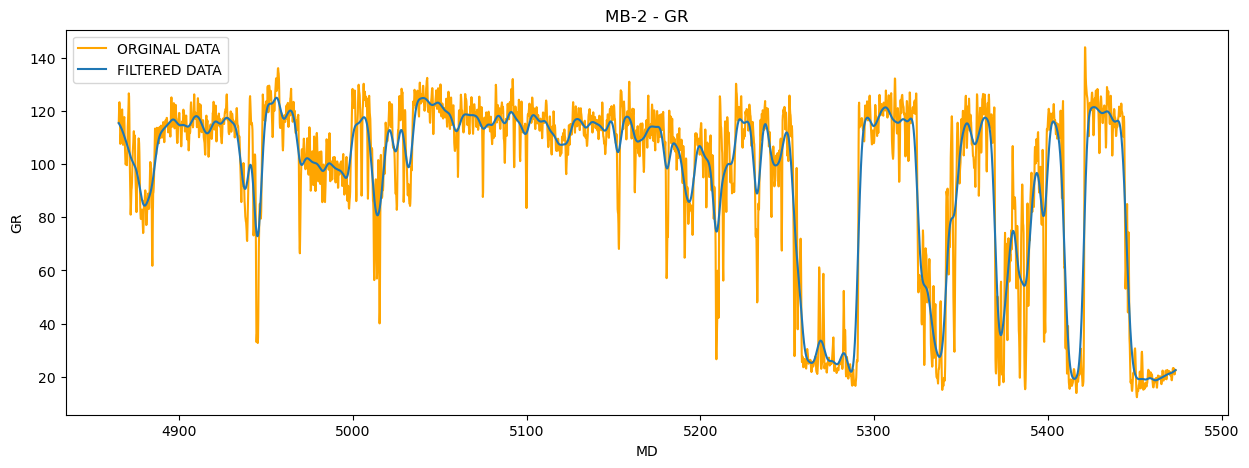

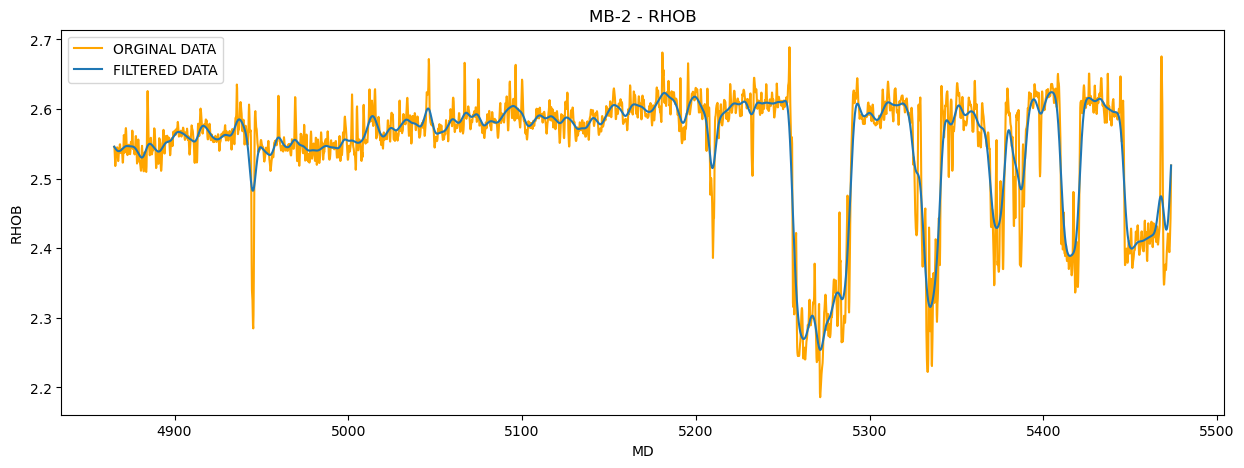

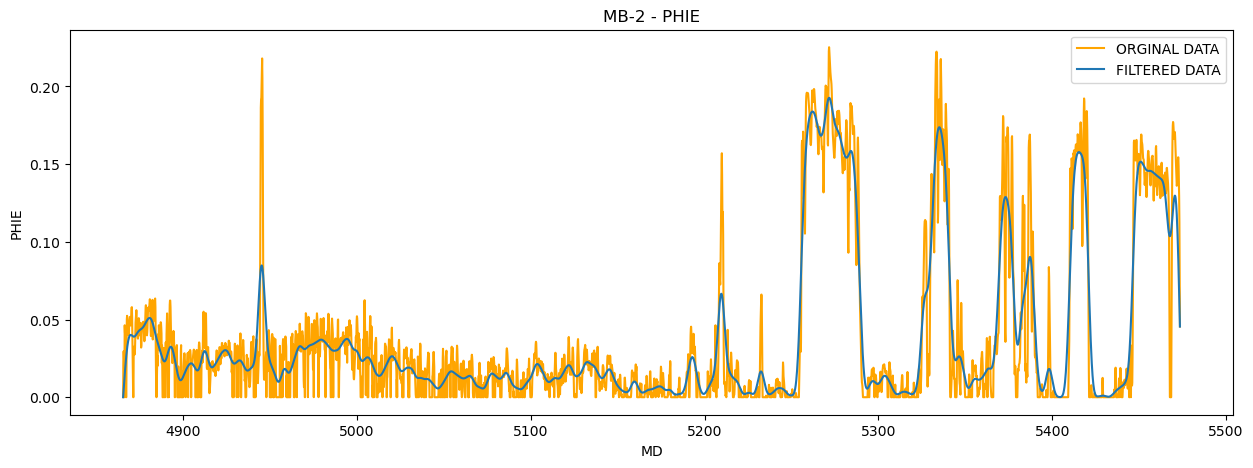

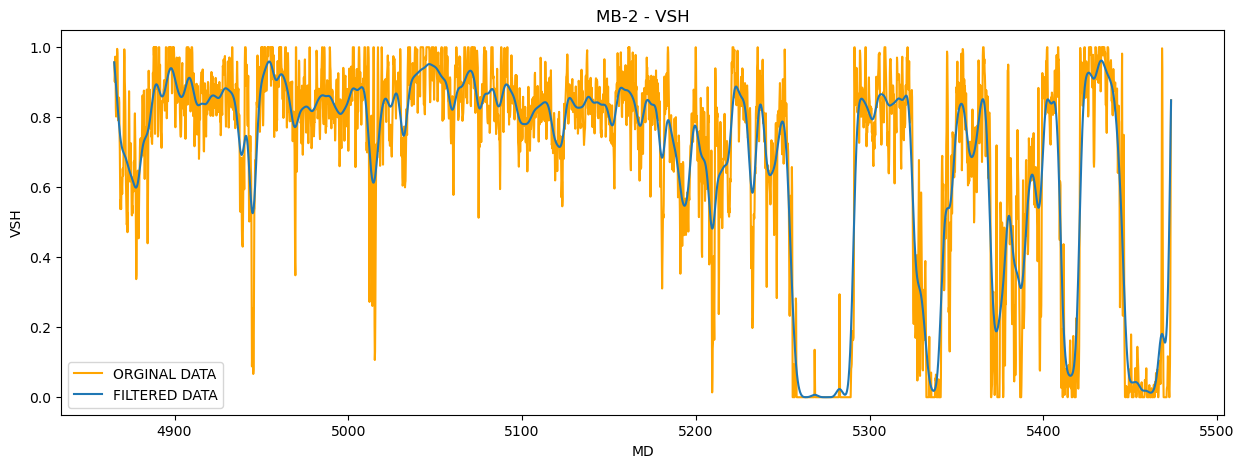

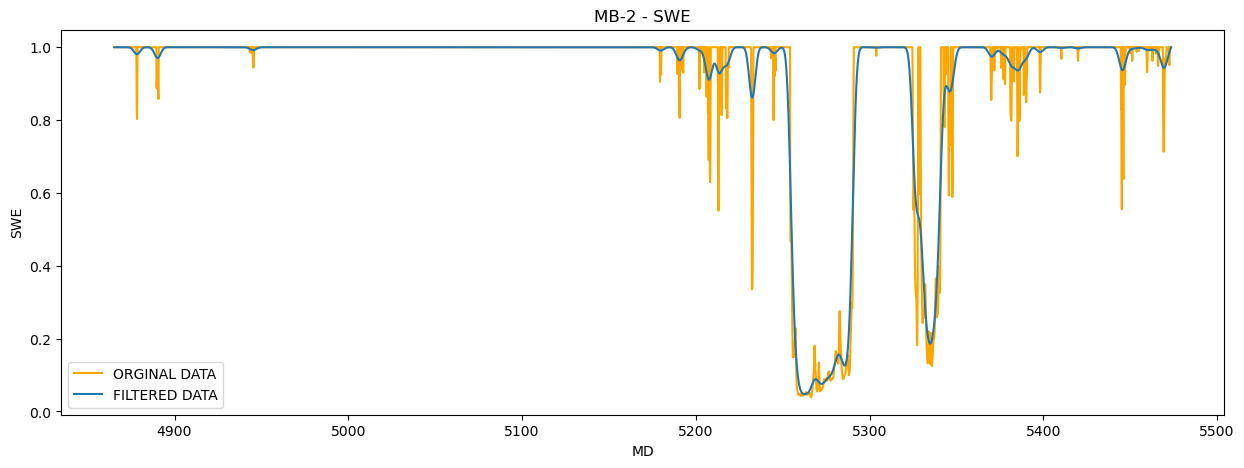

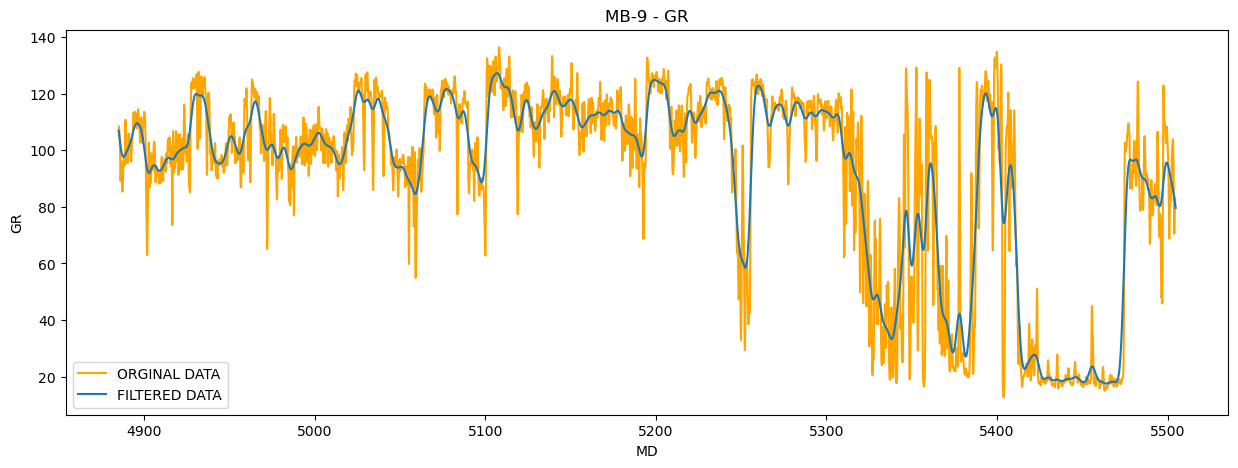

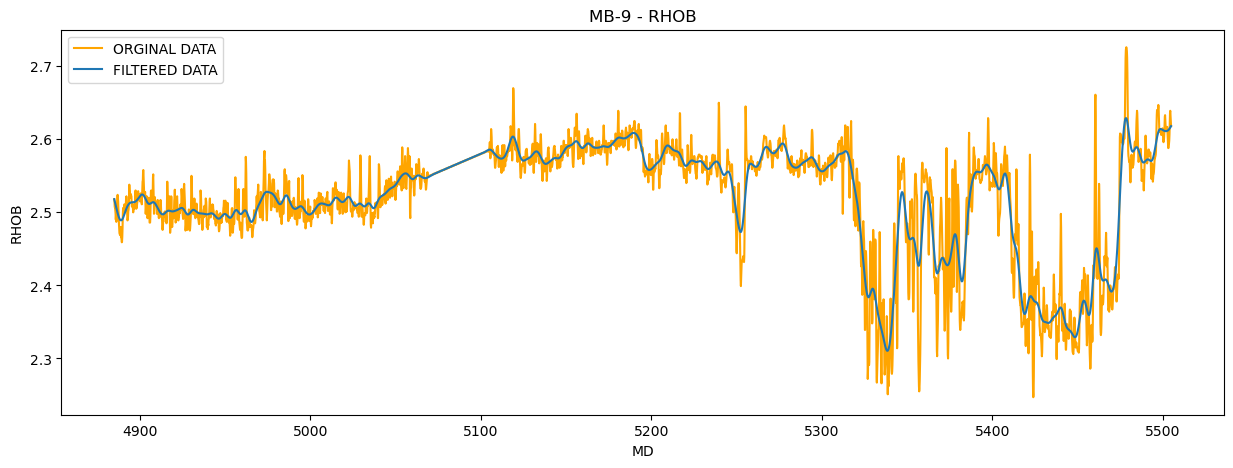

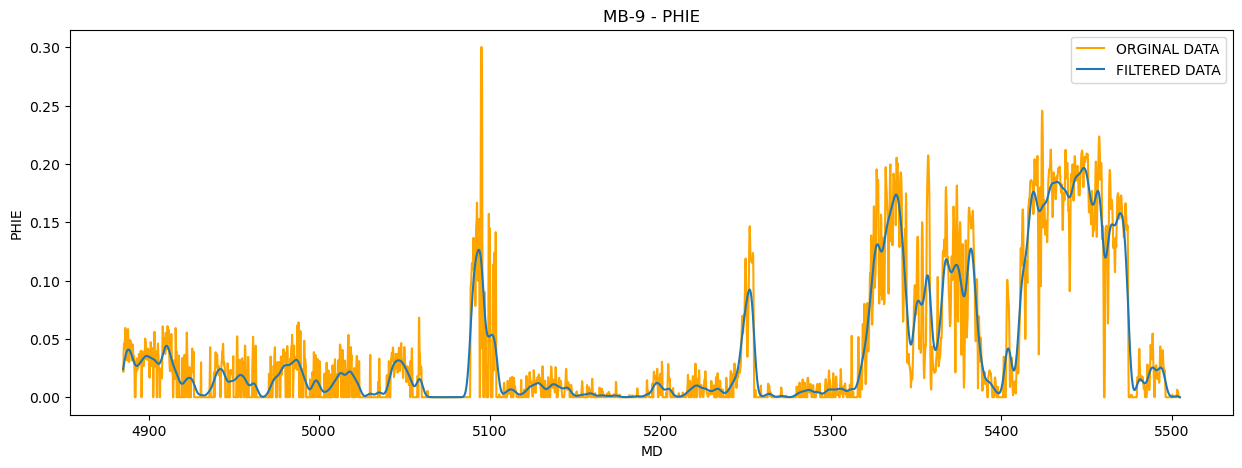

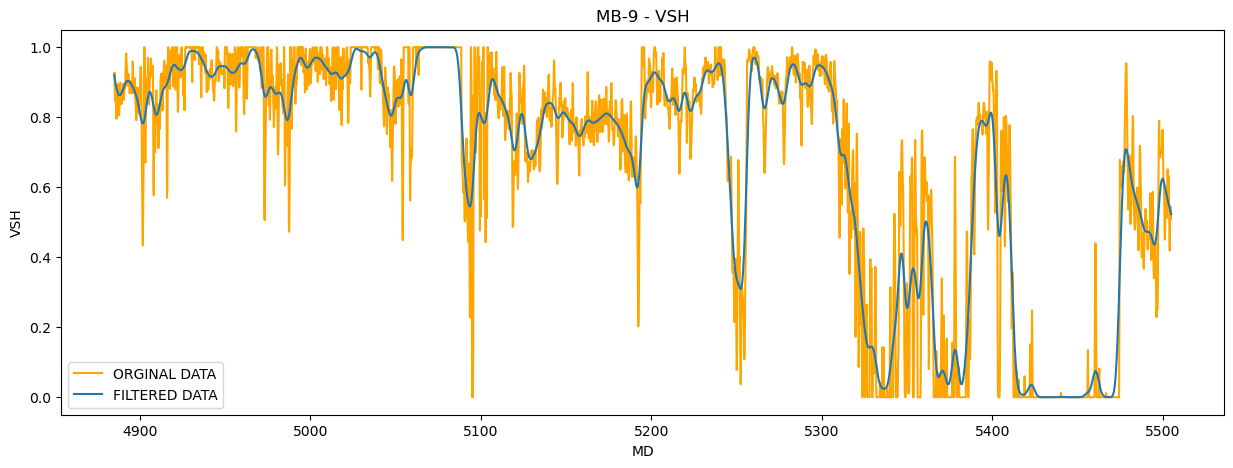

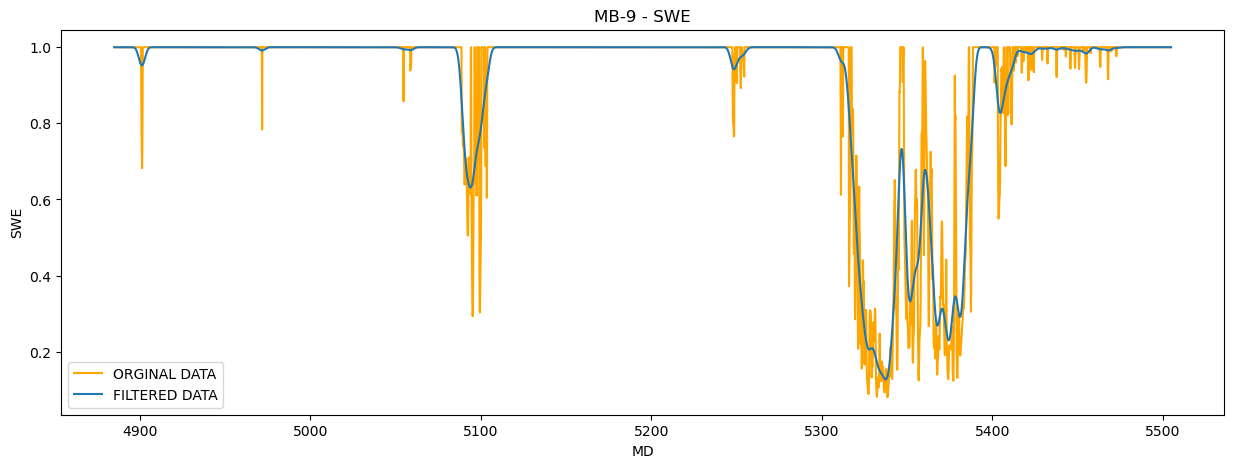

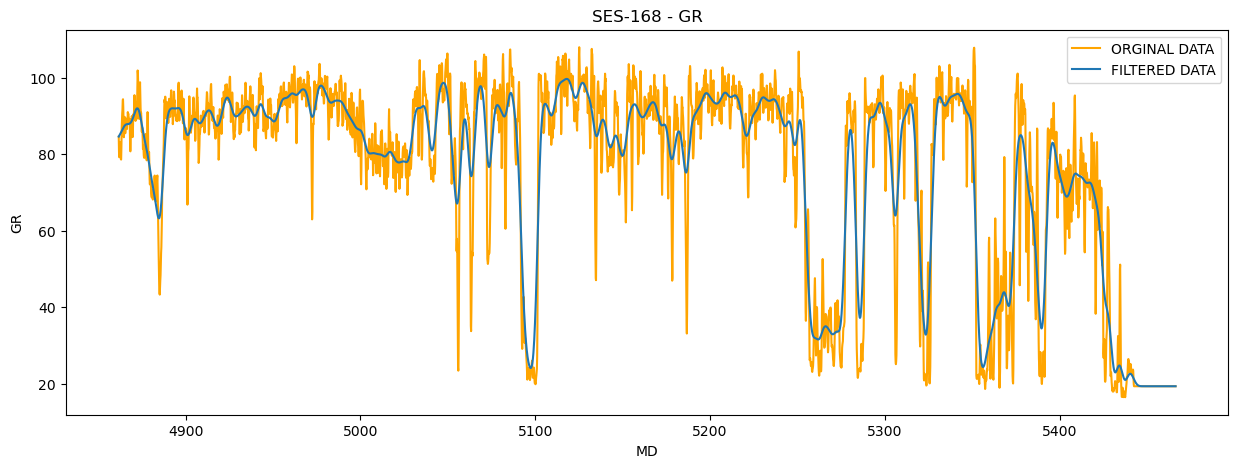

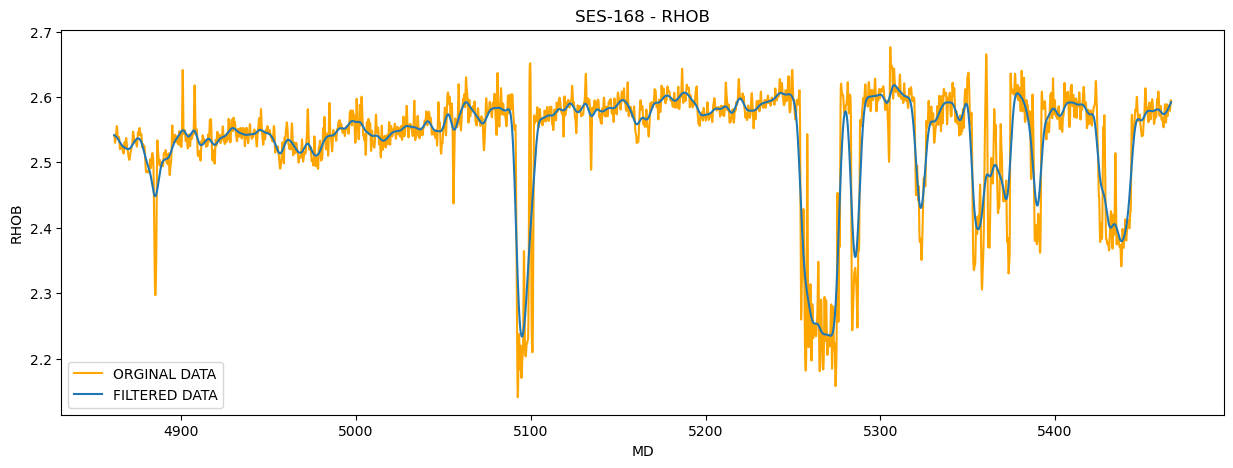

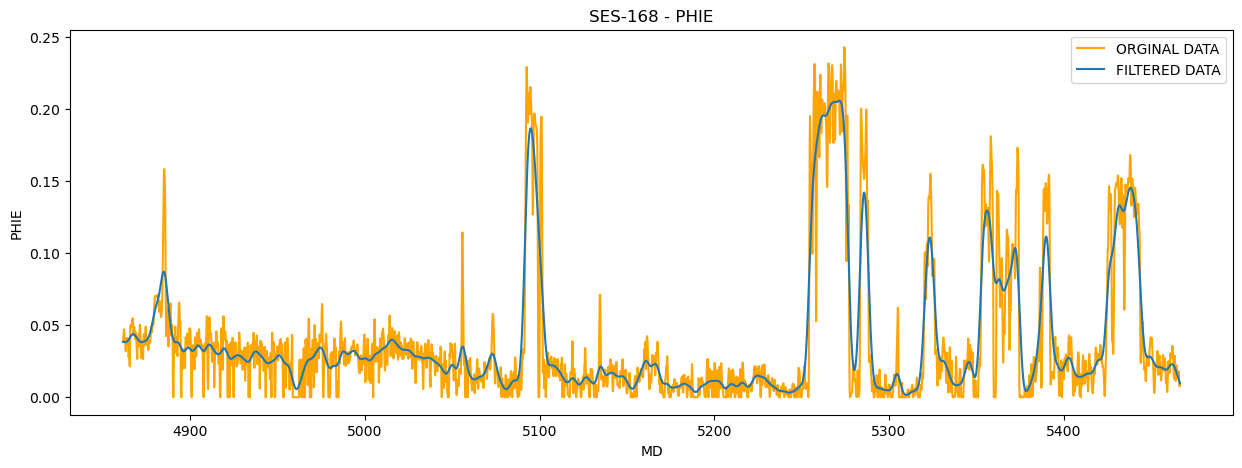

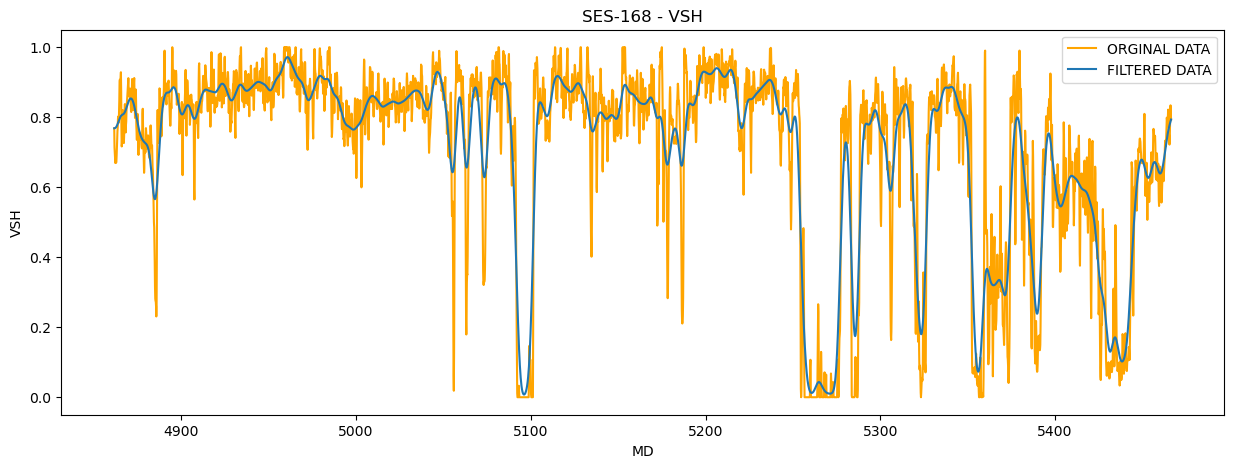

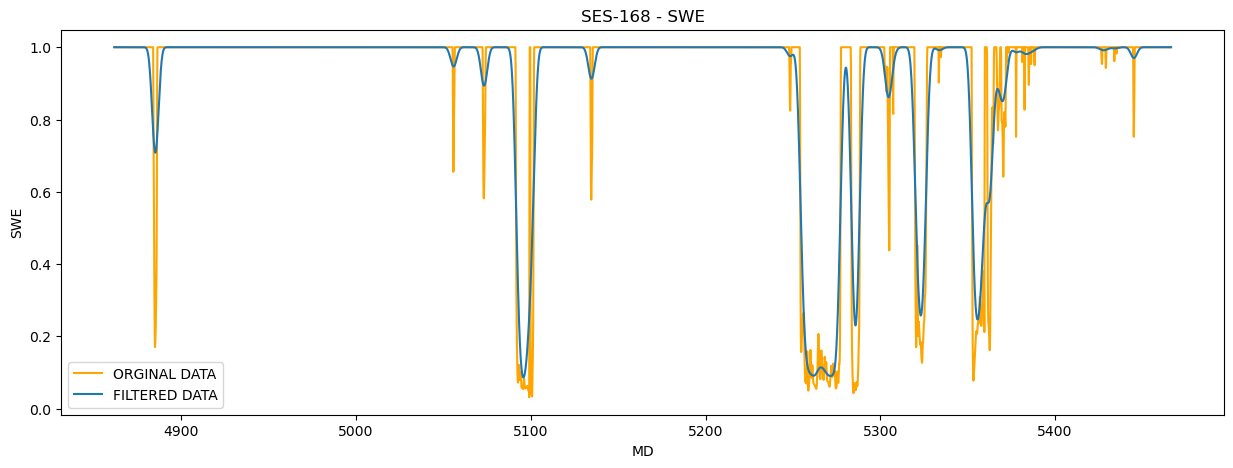

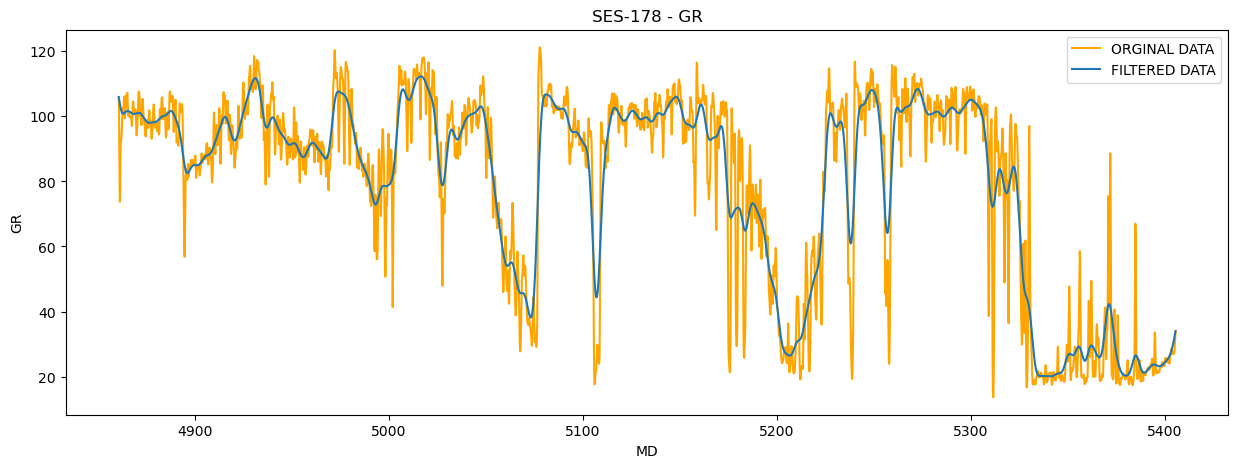

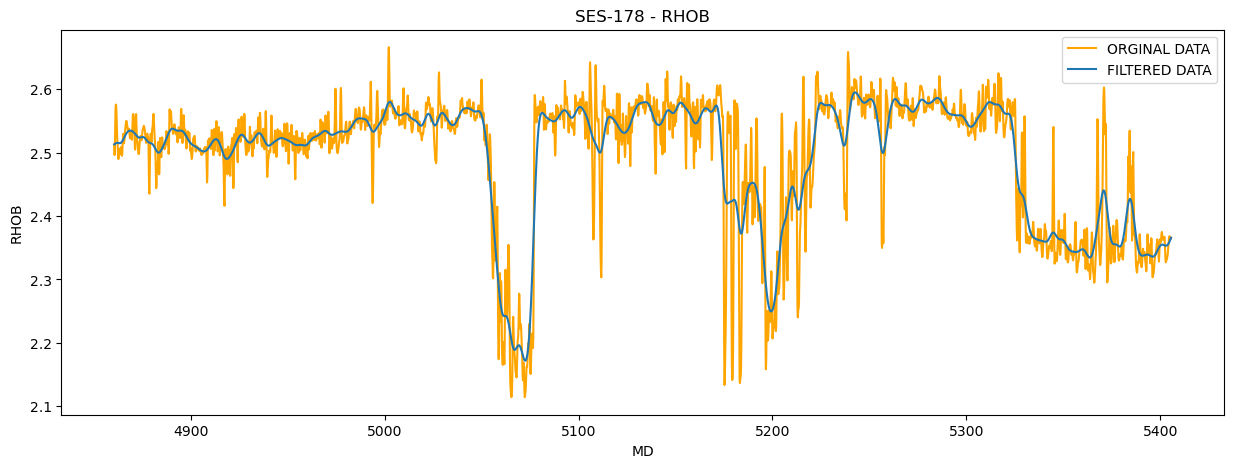

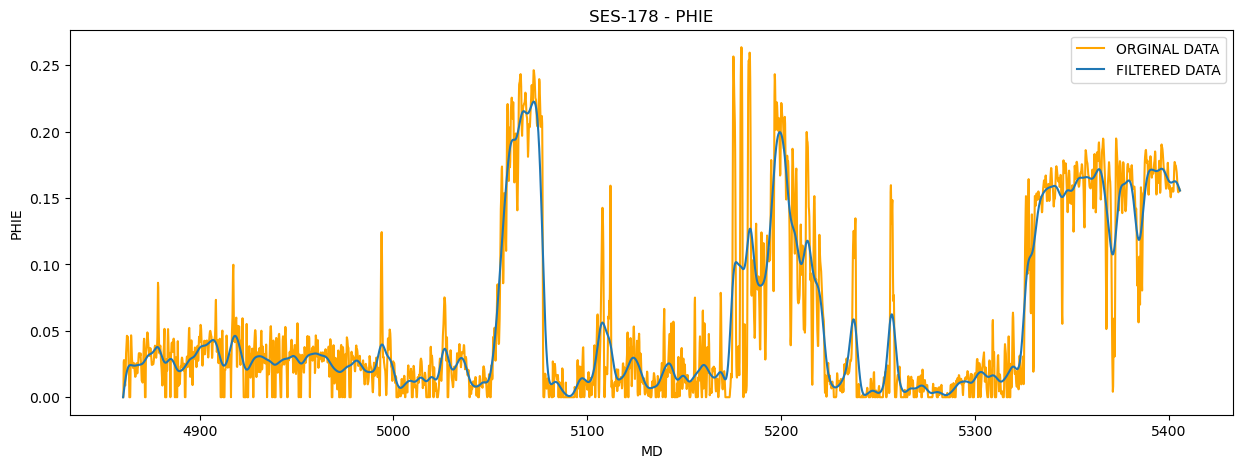

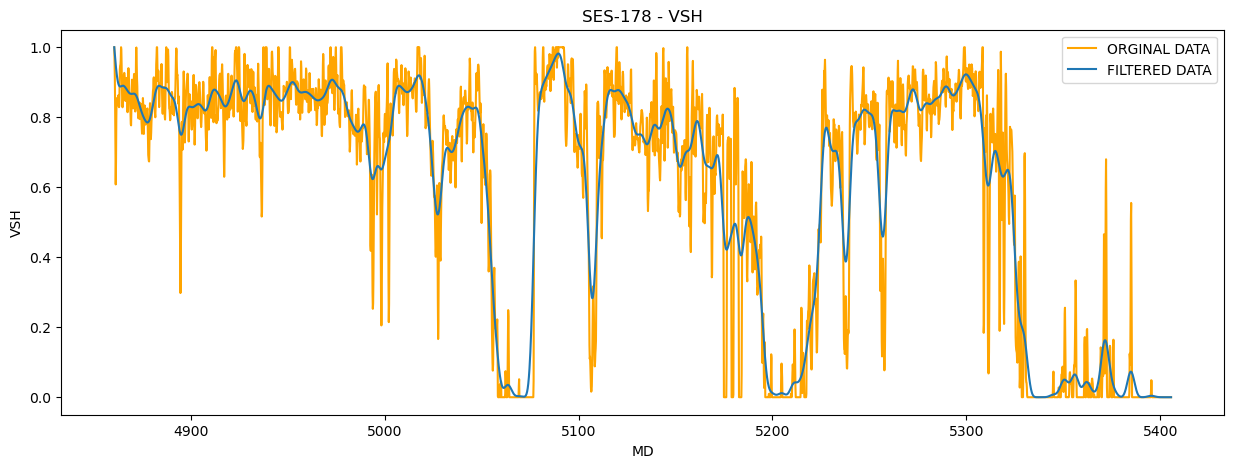

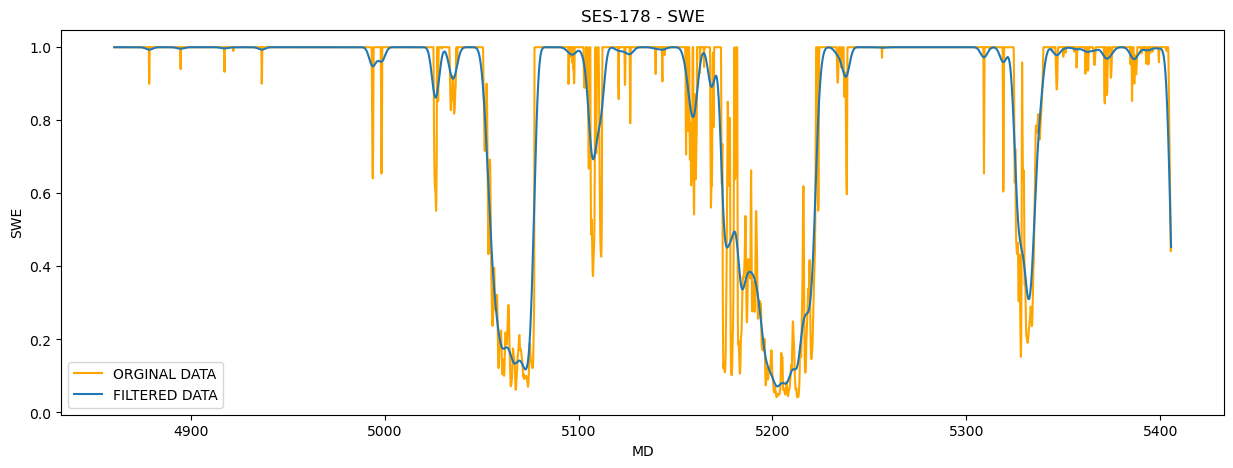

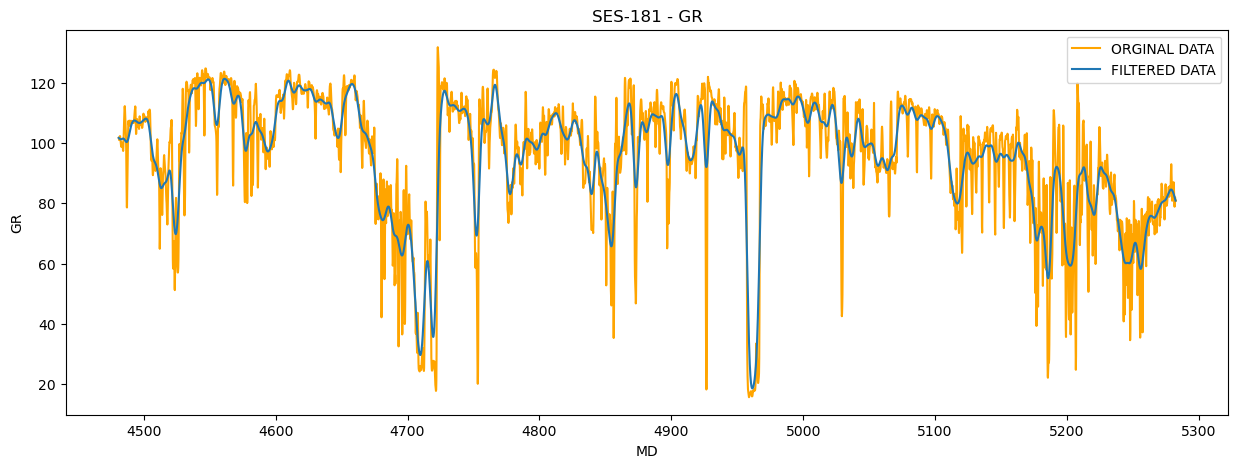

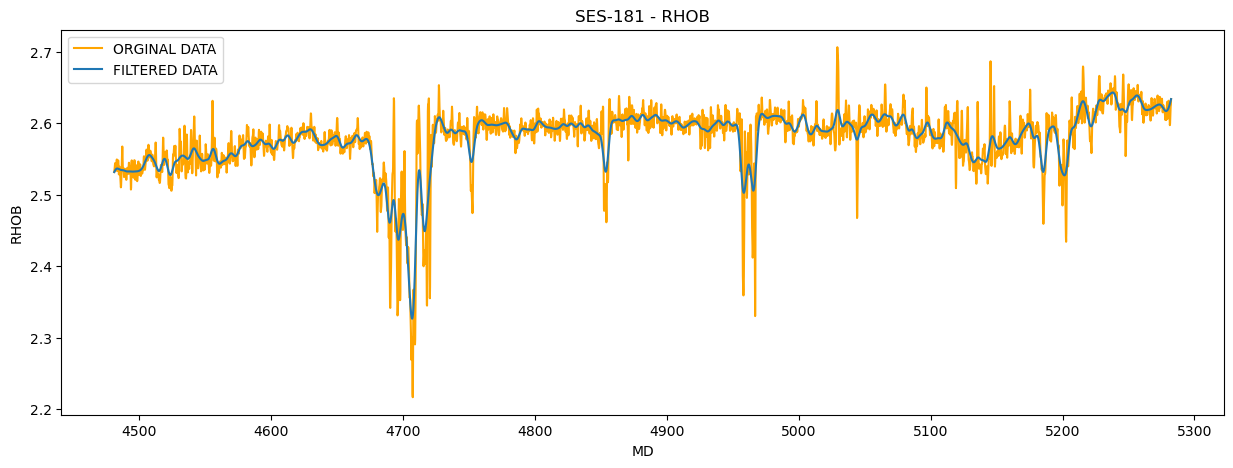

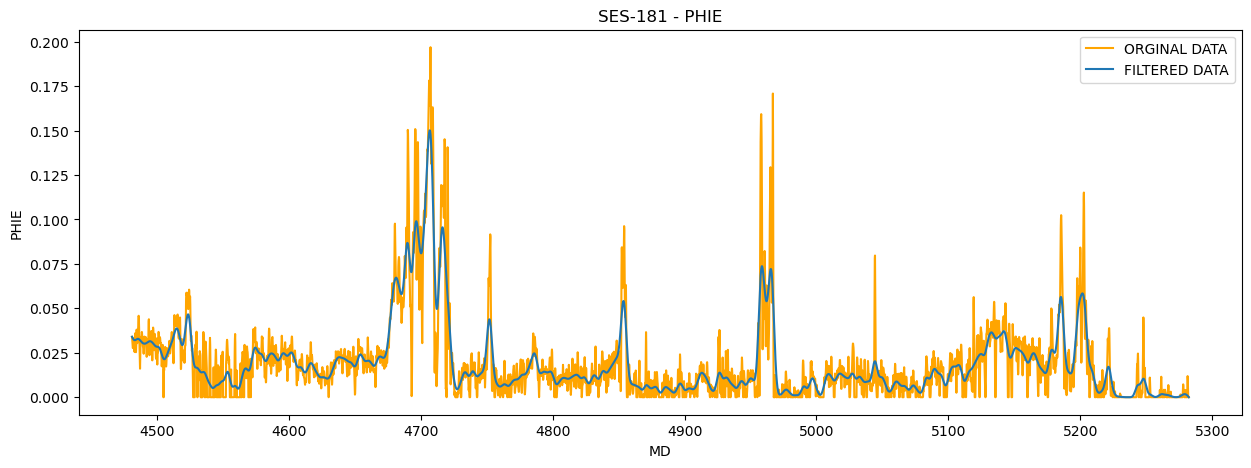

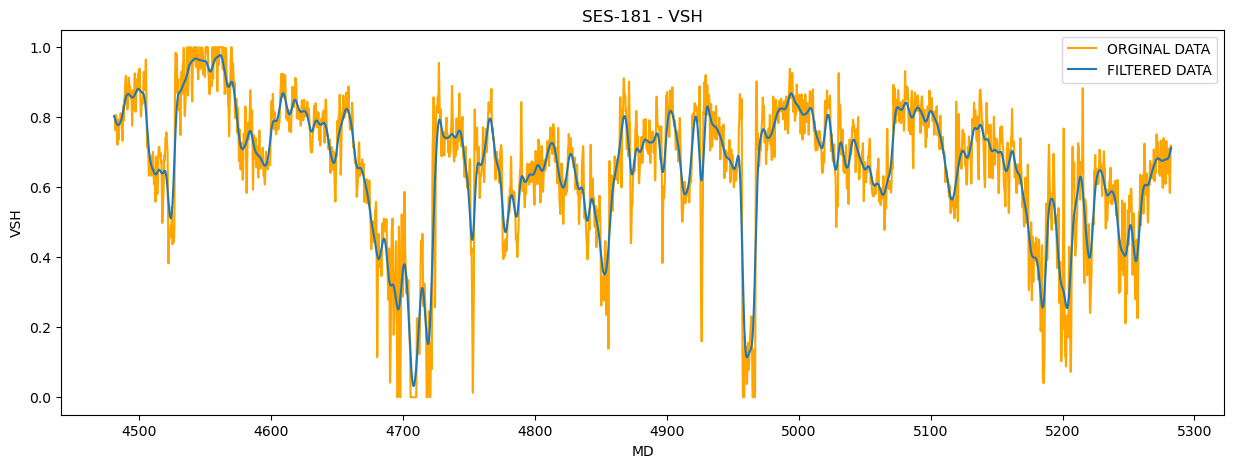

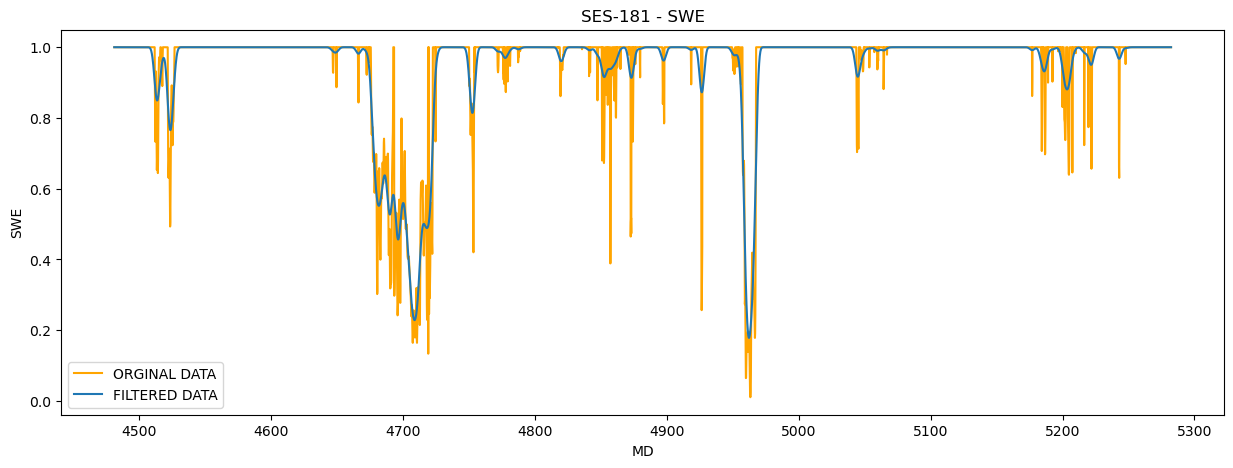

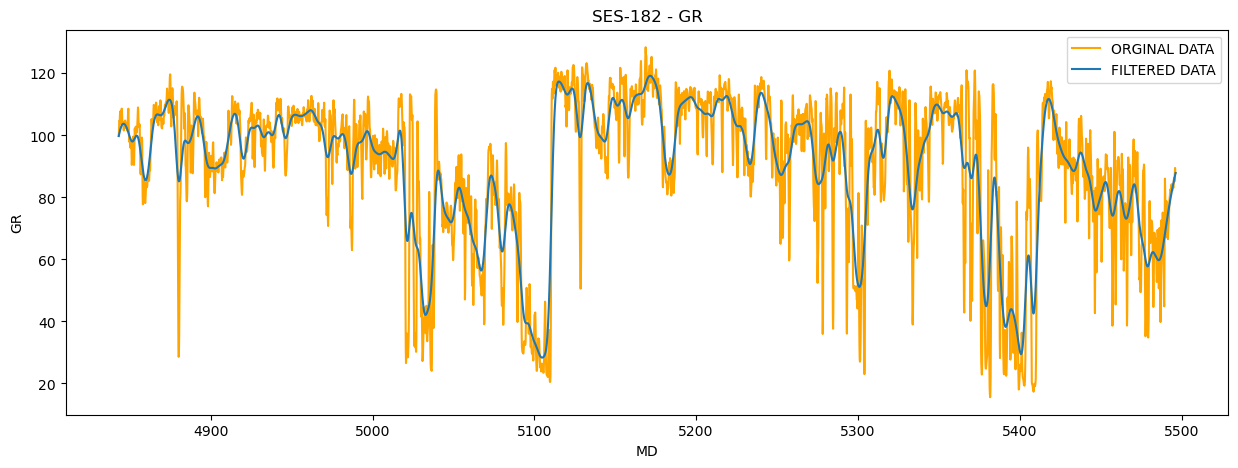

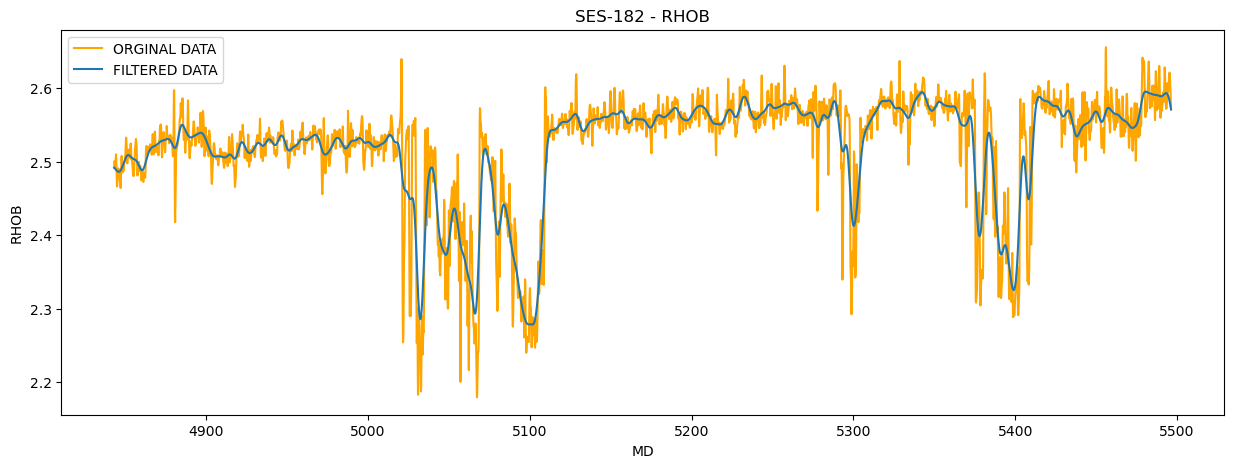

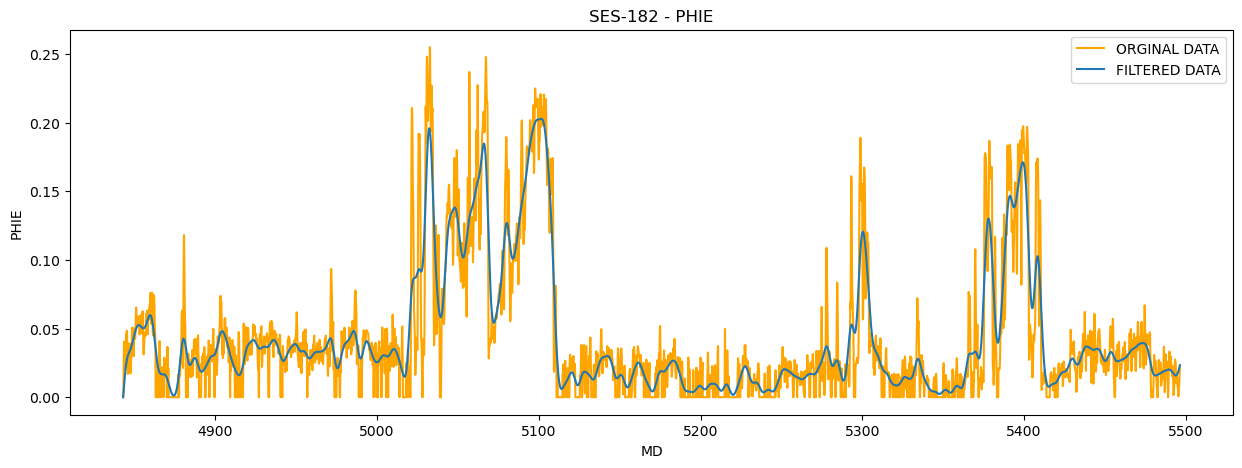

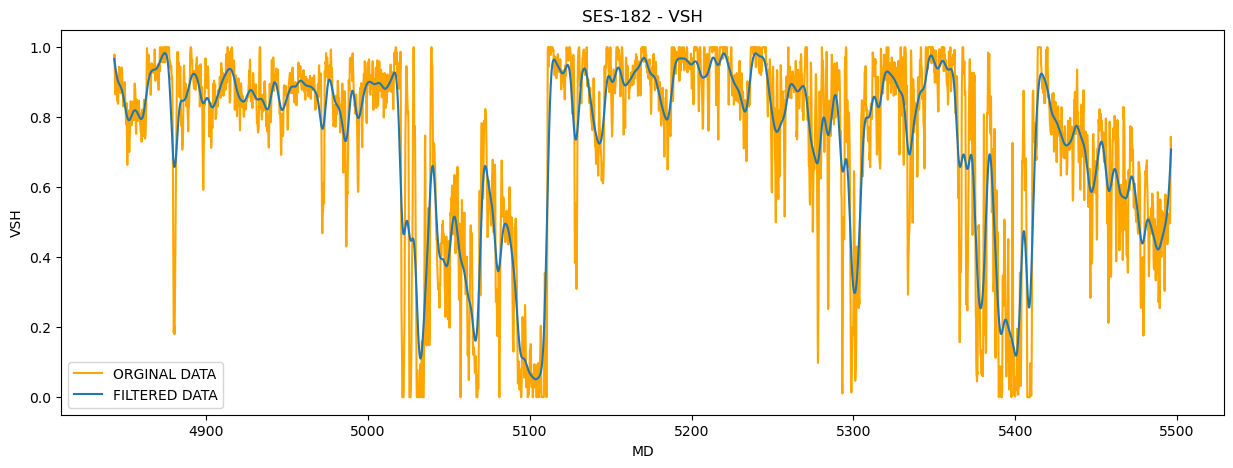

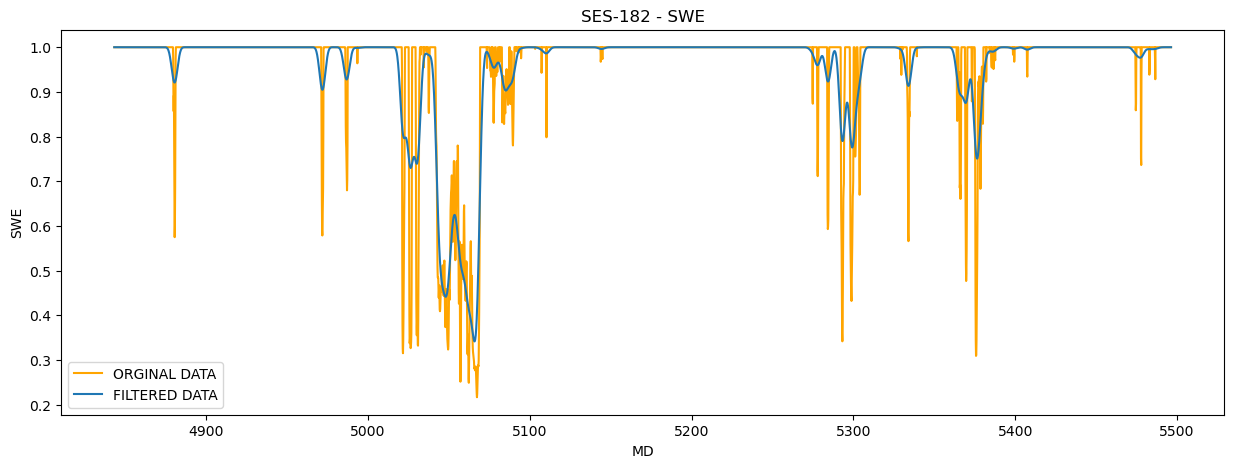

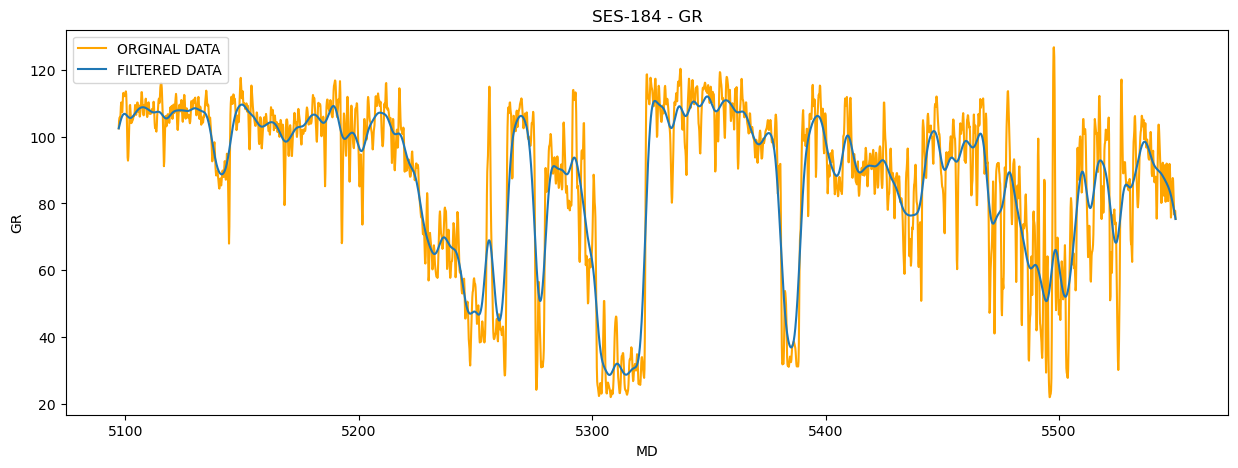

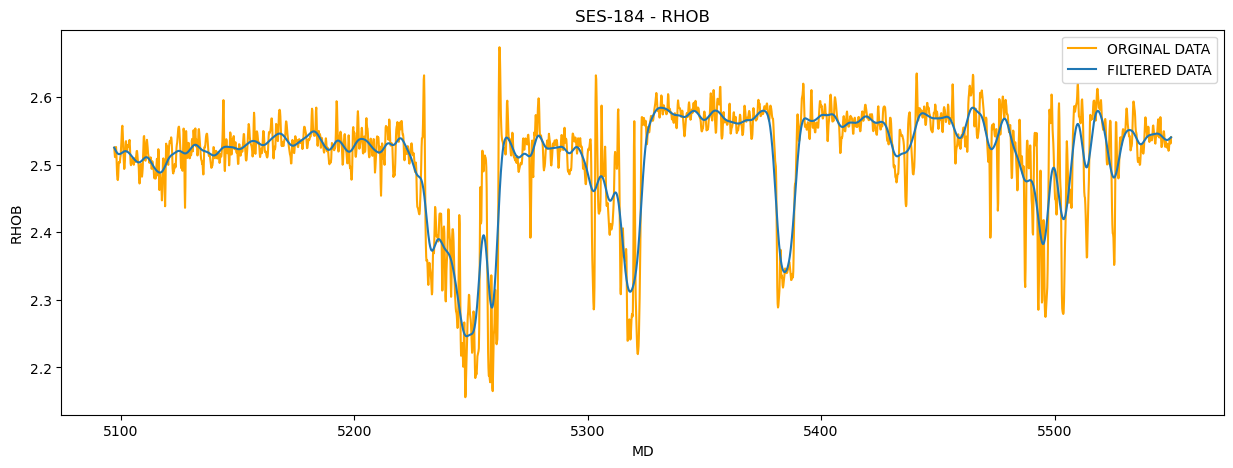

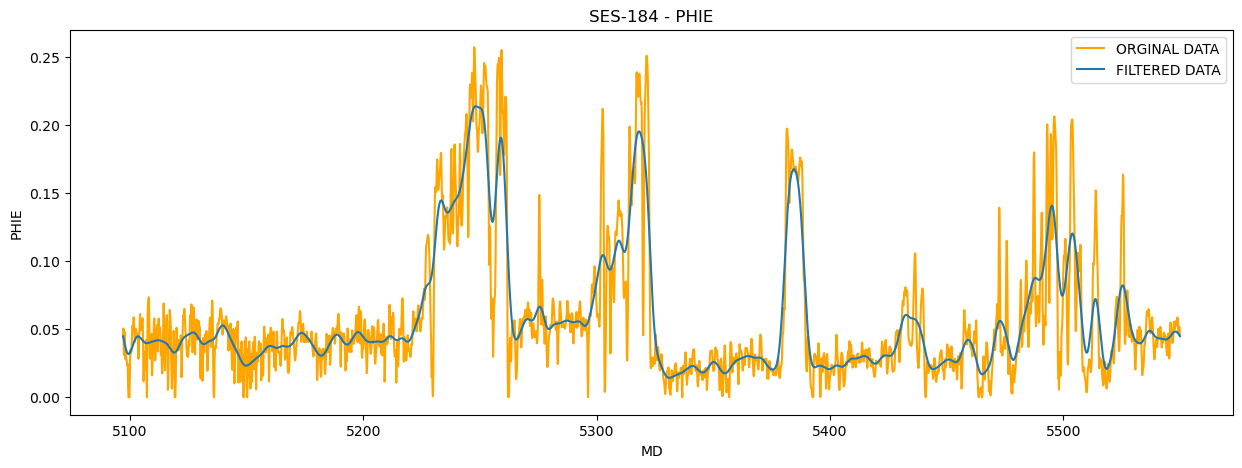

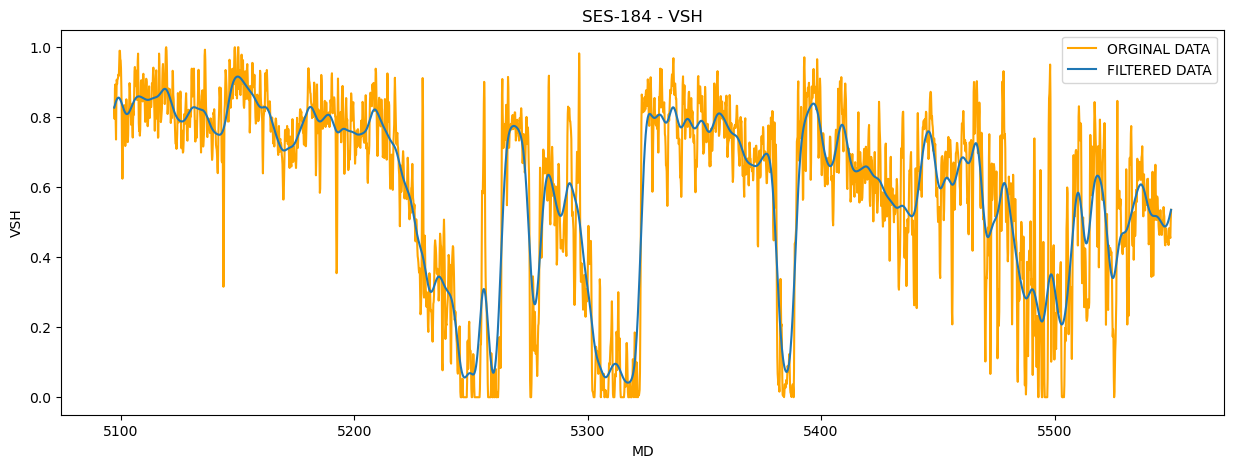

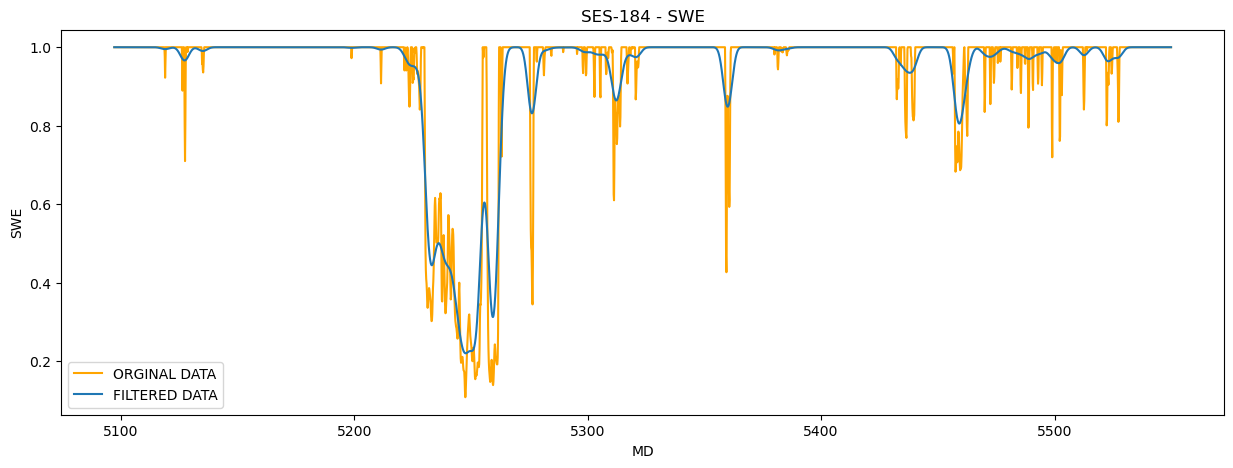

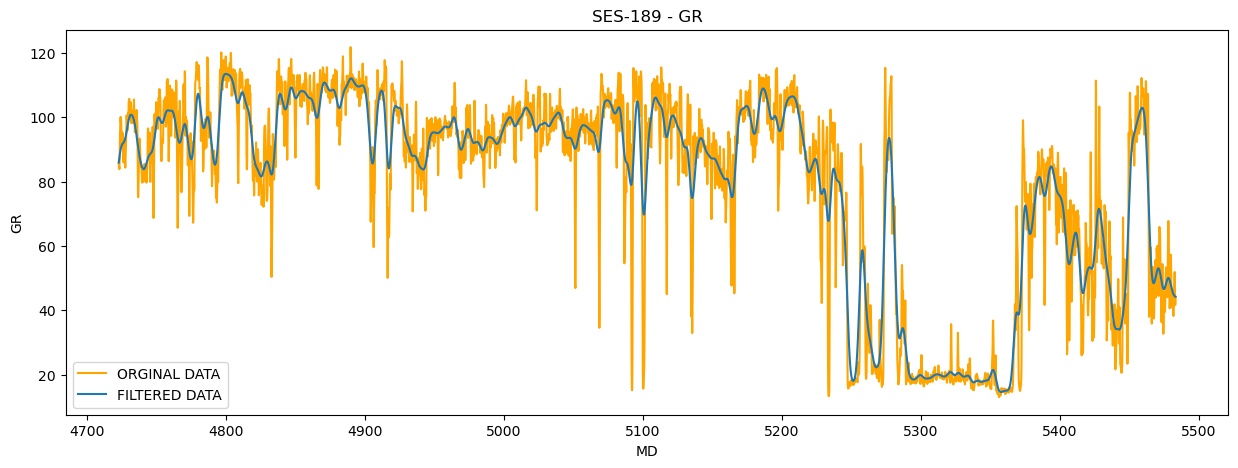

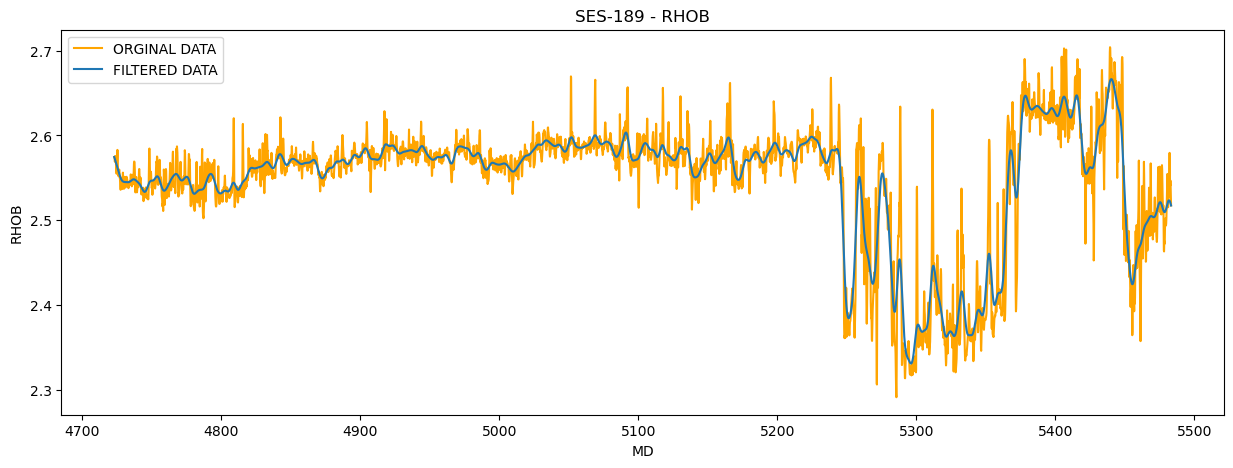

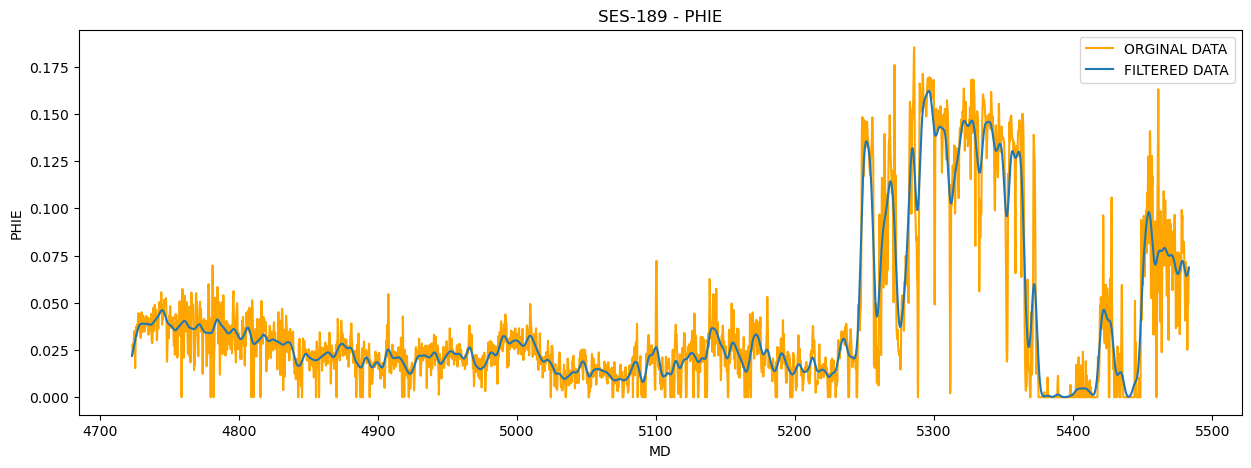

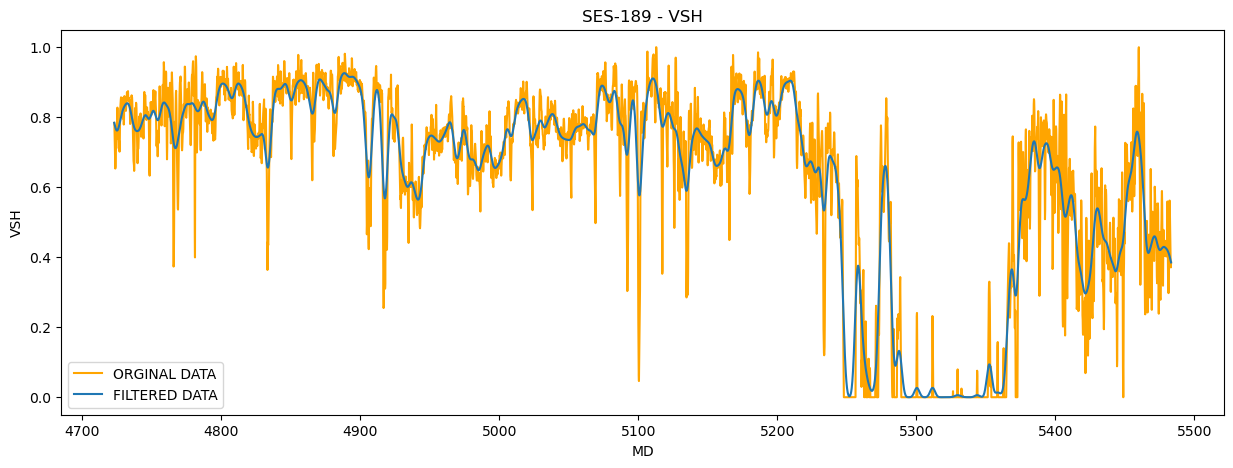

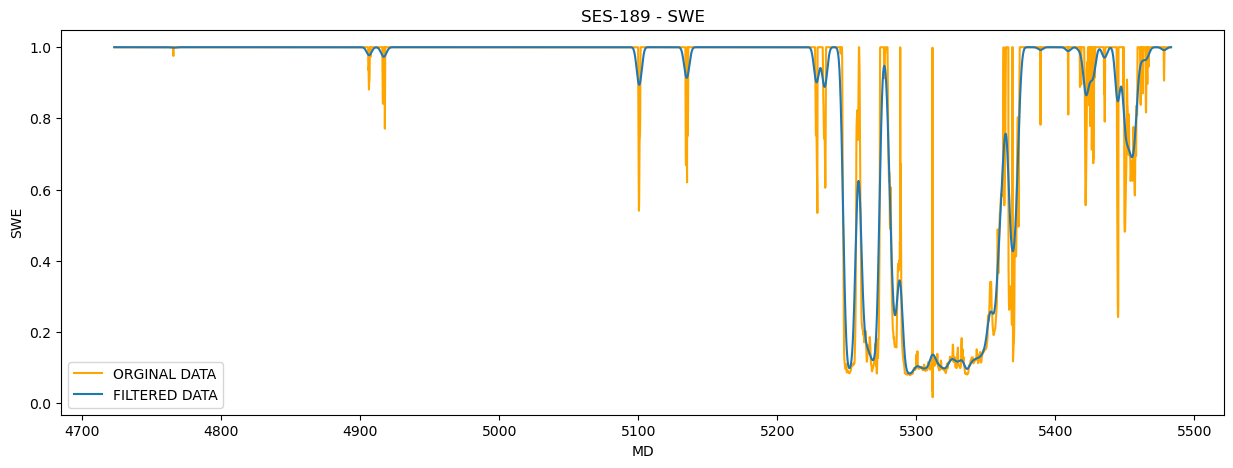

In [11]:
 def filter_all_wells(df_well_og, n, m):
    filtered_data = pd.DataFrame()
    for well in df_well_og['WELL'].unique():
        dfff = df_well_og[df_well_og['WELL'] == well]
        well_filtered = {'WELL': well, 'MD': dfff['MD'].values}
        for feature in dfff.columns:
            if feature in ['WELL', 'MD']:  # to skip 'WELL' and 'MD'
                continue
            data = dfff[feature].values
            if len(data) < n:
                print(f"Filter order 'n' is greater than the length of the data for well {well} and feature {feature}.")
                continue
            dt = (dfff['MD'].values[1] - dfff['MD'].values[0]).round(4)  
            fNQ = 1 / dt / 2
            if m <= 0 or m >= fNQ:
                print(f"Cutoff frequency 'm' must be between 0 and the Nyquist frequency for well {well} and feature {feature}.")
                continue
            Wn = m / fNQ
            b = firwin(n, Wn)
            filtered_values = filtfilt(b, 1, data)
            well_filtered[feature] = filtered_values
#             well_filtered[feature + '_filtered'] = filtered_values
            
        filt=pd.DataFrame(well_filtered)
        filt=filt.sort_values(by='MD')
#         display(filt)

        for feature in filt.columns:
            if f"{well}_" in feature or feature in ['MD', 'WELL']:
                continue
            plt.figure(figsize=(15, 5))
            plt.plot(dfff['MD'], dfff[feature], color='orange', label='ORGINAL DATA')
            plt.plot(filt['MD'], filt[feature], label="FILTERED DATA")
            plt.xlabel('MD')
            plt.ylabel(feature)
            plt.title(f'{well} - {feature}')
            plt.legend()
            plt.show()
            
        filtered_data = pd.concat([filtered_data, filt], ignore_index=True)
    return filtered_data

n = int(input("Enter Filter Order (n): "))
m = float(input("Enter Cutoff Frequency (m): "))
df_well = filter_all_wells(df_well_og, n, m)
# display(filtered_data)

TDR data

In [13]:
import os
import pandas as pd

def tdr_data(folder_path, skip_rows):
    df_tdr = pd.DataFrame()

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.txt'):
            with open(file_path, 'r') as file:
                dataframe1 = pd.read_csv(file, skiprows=skip_rows, header=None, sep="\s+|\t")
                dataframe1['Well name'] = filename.split("_")[0]
                print(dataframe1)
                # df_tdr = df_tdr.append(dataframe1, ignore_index=True)
                df_tdr = pd.concat([df_tdr, dataframe1], ignore_index=True) #Aakash_modified_as_append_function_has_deprected
        
    df_tdr = df_tdr.rename(columns={0: 'MD',      
        1: 'TWT'})
    df_tdr = df_tdr[df_tdr != -999.2500]
    df_tdr = df_tdr.dropna()
    df_tdr = df_tdr.reset_index(drop=True)
    
    return df_tdr

if __name__ == "__main__":
    folder_path = select_folder()
    if folder_path:
        try:
            print("OVL skip 1 row")
            skip_rows = int(input("Enter the number of rows to skip: "))
            
            df_tdr = tdr_data(folder_path, skip_rows)
            display(df_tdr)
        except Exception as e:
            print(f"Error processing files: {e}")
    else:
        print("No folder selected")

No folder selected


In [14]:
len(df_tdr['Well name'].unique())

8

Deviation Data 

In [18]:
def dev_data(folder_path,skip_rows):
    df_dev = pd.DataFrame()
    # df = pd.concat([df, pd.DataFrame([{'a':1, 'b':2}])], ignore_index=True)

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'rb') as file:
            df=pd.read_csv(file,skiprows=skip_rows,header=None,sep=" ")

            df=df.iloc[:,0:4]
            df['Well name']=filename
            df_dev = pd.concat([df_dev, df], ignore_index=True)
            # df_dev=df_dev.append(df)
    df_dev=df_dev.drop(columns=0)
    df_dev=df_dev.rename(columns={1:'MD',2:'X',3:'Y'})
    df_dev=df_dev.dropna()
    return df_dev

if __name__ == "__main__":
    folder_path = select_folder()
    if folder_path:
        try:
            print("OVL skip 18 row")
            skip_rows=int(input("Enter the number of rows to skip :"))
            df_dev = dev_data(folder_path,skip_rows)
            display(df_dev)
        except Exception as e:
            print(f"Error processing files: {e}")
    else:
        print("No folder selected")

OVL skip 18 row


Enter the number of rows to skip : 18


MD             X             Y Well name
0         0.0  782939.00000  8.755838e+06      MB-2
1      2654.0  782939.00000  8.755838e+06      MB-2
2      2795.0  782939.05451  8.755838e+06      MB-2
3      2875.0  782939.11478  8.755837e+06      MB-2
4      2914.0  782939.12211  8.755837e+06      MB-2
...       ...           ...           ...       ...
12190  5187.0  776107.47859  8.732746e+06   SES-191
12191  5230.0  776107.29803  8.732745e+06   SES-191
12192  5308.0  776107.02080  8.732743e+06   SES-191
12193  5343.0  776106.96690  8.732742e+06   SES-191
12194  5395.0  776106.91997  8.732741e+06   SES-191

[12191 rows x 4 columns]

In [17]:
len(df_dev['Well name'].unique())

9

In [19]:
def update_well_twt(df_well, df_tdr):
    dfm = pd.DataFrame()
    for well_name in df_tdr['Well name'].unique():
        df_ms = df_well[df_well['WELL'] == well_name]
        df_n = df_tdr[df_tdr['Well name'] == well_name]
        
        if df_n.empty or df_ms.empty:
            continue
        X = df_n[['MD']].values
        Y = df_n[['TWT']].values
        knr = KNeighborsRegressor(n_neighbors=1)
        knr.fit(X, Y)
        X_pred = df_ms[['MD']].values
        X_Y = knr.predict(X_pred)
        df_ms[['TWT']] = X_Y
        dfm = pd.concat([dfm, df_ms], ignore_index=True)
    return dfm

In [20]:
dfm = update_well_twt(df_well, df_tdr)

In [21]:
def update_well_coordinates(dfm, df_dev):
    dfg = pd.DataFrame()
    for well_name in dfm['WELL'].unique():
        df_ms = dfm[dfm['WELL'] == well_name]
        df_n = df_dev[df_dev['Well name'] == well_name]
        if df_n.empty or df_ms.empty:
            continue
        X = df_n[['MD']].values
        Y = df_n[['X', 'Y']].values
        knr = KNeighborsRegressor(n_neighbors=1)
        knr.fit(X, Y)
        X_pred = df_ms[['MD']].values
        X_Y = knr.predict(X_pred)
        df_ms[['X', 'Y']] = X_Y
        dfg = pd.concat([dfg, df_ms], ignore_index=True)
    return dfg

In [22]:
dfg=update_well_coordinates(dfm, df_dev)
dfg

WELL         MD          GR      RHOB      PHIE       VSH       SWE  \
0         MB-2  4865.2886  115.486900  2.545900  0.000034  0.956844  1.000000   
1         MB-2  4865.4414  115.310328  2.545293  0.002506  0.947209  1.000000   
2         MB-2  4865.5938  115.132129  2.544692  0.004967  0.937552  1.000000   
3         MB-2  4865.7461  114.950777  2.544104  0.007406  0.927856  1.000000   
4         MB-2  4865.8984  114.764945  2.543533  0.009811  0.918102  1.000000   
...        ...        ...         ...       ...       ...       ...       ...   
33105  SES-189  5482.5356   44.400164  2.521144  0.066062  0.395823  0.999769   
33106  SES-189  5482.6880   44.344962  2.520319  0.066649  0.393228  0.999838   
33107  SES-189  5482.8403   44.297090  2.519421  0.067284  0.390577  0.999897   
33108  SES-189  5482.9927   44.254301  2.518473  0.067950  0.387888  0.999950   
33109  SES-189  5483.1450   44.214100  2.517500  0.068633  0.385181  1.000000   

             TWT             X             Y  
0      5387.3789  782936.52816  8.755825e+06  
1      5387.3789  782936.52816  8.755825e+06  
2      5387.3789  782936.52816  8.755825e+06  
3      5387.3789  782936.52816  8.755825e+06  
4      5387.3789  782936.52816  8.755825e+06  
...          ...           ...           ...  
33105  5632.7056  773339.66067  8.754838e+06  
33106  5632.7056  773339.66067  8.754838e+06  
33107  5632.7056  773339.66067  8.754838e+06  
33108  5632.7056  773339.66067  8.754838e+06  
33109  5633.9790  773339.66067  8.754838e+06  

[33110 rows x 10 columns]

In [23]:
dfg1=dfg[~dfg['WELL'].isin(['SES-181','SES-189', 'SES-178', 'SES-182', 'SES-184'])]

In [24]:
dfg1.WELL.unique()

array(['MB-2', 'MB-9', 'SES-168'], dtype=object)

In [25]:
df_s1.columns

Index(['index', 'inline', 'xline', 'X', 'Y', 'TWT', 'Env', 'Inst.Fq',
       'Inst.Ph', 'LFI', 'LR', 'PR', 'VPVS', 'Zp'],
      dtype='object')

In [26]:
dfg1

WELL         MD          GR      RHOB      PHIE       VSH  SWE  \
0         MB-2  4865.2886  115.486900  2.545900  0.000034  0.956844  1.0   
1         MB-2  4865.4414  115.310328  2.545293  0.002506  0.947209  1.0   
2         MB-2  4865.5938  115.132129  2.544692  0.004967  0.937552  1.0   
3         MB-2  4865.7461  114.950777  2.544104  0.007406  0.927856  1.0   
4         MB-2  4865.8984  114.764945  2.543533  0.009811  0.918102  1.0   
...        ...        ...         ...       ...       ...       ...  ...   
12023  SES-168  5465.7798   19.290899  2.588082  0.012087  0.782620  1.0   
12024  SES-168  5465.9326   19.290899  2.589029  0.011489  0.785394  1.0   
12025  SES-168  5466.0850   19.290899  2.589983  0.010890  0.788093  1.0   
12026  SES-168  5466.2373   19.290899  2.590940  0.010290  0.790741  1.0   
12027  SES-168  5466.3896   19.290899  2.591900  0.009689  0.793363  1.0   

             TWT             X             Y  
0      5387.3789  782936.52816  8.755825e+06  
1      5387.3789  782936.52816  8.755825e+06  
2      5387.3789  782936.52816  8.755825e+06  
3      5387.3789  782936.52816  8.755825e+06  
4      5387.3789  782936.52816  8.755825e+06  
...          ...           ...           ...  
12023  5863.5195  787283.06553  8.752662e+06  
12024  5863.5195  787283.06583  8.752662e+06  
12025  5864.6108  787283.06613  8.752662e+06  
12026  5864.6108  787283.06642  8.752662e+06  
12027  5864.6108  787283.06672  8.752662e+06  

[12028 rows x 10 columns]

In [29]:
def seismic_trace(train_df, test_df, feature_cols, target_cols, n_neighbors=1):
    x_train = train_df[feature_cols]
    y_train = train_df[target_cols]
    x_test = test_df[feature_cols]
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    result_df = test_df.copy()
    result_df[target_cols] = predictions
    return result_df

# dfg1 = seismic_trace(df_s1, dfg1, ['TWT','X','Y'], ['Env', 'Inst.Fq',
       # 'Inst.Ph', 'LFI', 'LR', 'PR', 'VPVS', 'Zp', 'Phase_Sft', 'RI', 'RMS',
       # 'SD15', 'SD30', 'SD60', 'Sweetness'])
dfg1 = seismic_trace(df_s1, dfg1, ['TWT','X','Y'], ['Env', 'Inst.Fq',
       'Inst.Ph', 'LFI', 'LR', 'PR', 'VPVS', 'Zp'])

In [30]:
from PyQt5.QtWidgets import QApplication, QFileDialog
def select_file():
    app = QApplication([])  
    file_path, _ = QFileDialog.getOpenFileName(None, "Select a File")
    return file_path

In [33]:
import pandas as pd

def reservoir(file_path, dfg):
    m = int(input("Enter the offset value +: "))
    n = int(input("Enter the offset value -: "))
    
    well_tops = pd.read_csv(file_path, sep="\t")
    unique_well_names = dfg['WELL'].unique()
    filtered_well_tops = well_tops[well_tops['Well Name'].isin(unique_well_names)]
    df_hor_range = pd.DataFrame()
    
    for well in filtered_well_tops['Well Name'].unique():
        well_tops_for_well = filtered_well_tops[filtered_well_tops['Well Name'] == well]
        dfg_for_well = dfg[dfg['WELL'] == well]
        well_tops_unique = well_tops_for_well['Well Top'].unique()
        
        if 'Camp22_top' not in well_tops_unique:
            print(f"No 'Camp22_top' found for {well} ")
            print("top - 5105.26 ; bot - 5163.26  for ovl")
            top_md = float(input(f"Enter the top MD for {well}: ")) - n
            bot_md = float(input(f"Enter the bot MD for {well}: ")) + m
        else:
            print("Found 'Camp22_top'")
            top = well_tops_for_well[well_tops_for_well['Well Top'] == 'Camp22_top']
            top_md = top['MD'].iloc[0] - n
            bot = well_tops_for_well[well_tops_for_well['Well Top'] == 'Camp22_base ']
            bot_md = bot['MD'].iloc[0] + m
        
        dfg_filtered = dfg_for_well[(dfg_for_well['MD'] > top_md) & (dfg_for_well['MD'] < bot_md)]
        df_hor_range = pd.concat([df_hor_range, dfg_filtered], ignore_index=True)
        display(dfg_filtered)

    return df_hor_range

df_hor_range = reservoir(select_file(), dfg1)

Enter the offset value +:  100
Enter the offset value -:  100


Found 'Camp22_top'


WELL         MD          GR      RHOB      PHIE       VSH       SWE  \
5692  MB-9  5144.1470  116.358594  2.574196  0.008016  0.806300  1.000000   
5693  MB-9  5144.2993  116.188243  2.574127  0.008093  0.804302  1.000000   
5694  MB-9  5144.4517  116.035769  2.574053  0.008162  0.802514  1.000000   
5695  MB-9  5144.6040  115.902176  2.573980  0.008221  0.800967  1.000000   
5696  MB-9  5144.7563  115.788056  2.573915  0.008266  0.799684  1.000000   
...    ...        ...         ...       ...       ...       ...       ...   
7071  MB-9  5354.3066   76.224940  2.459622  0.083056  0.357149  0.400879   
7072  MB-9  5354.4590   75.600053  2.457828  0.084265  0.352670  0.404590   
7073  MB-9  5354.6113   74.876105  2.455791  0.085629  0.347582  0.407929   
7074  MB-9  5354.7637   74.067209  2.453532  0.087133  0.341982  0.410910   
7075  MB-9  5354.9160   73.189474  2.451082  0.088754  0.335979  0.413566   

            TWT             X             Y           Env      Inst.Fq  \
5692  5617.6626  777769.84170  8.747759e+06  22840.384766  2678.255127   
5693  5617.6626  777769.84170  8.747759e+06  22840.384766  2678.255127   
5694  5617.6626  777769.84170  8.747759e+06  22840.384766  2678.255127   
5695  5617.6626  777769.84170  8.747759e+06  22840.384766  2678.255127   
5696  5617.6626  777769.84170  8.747759e+06  22840.384766  2678.255127   
...         ...           ...           ...           ...          ...   
7071  5738.7827  777769.82491  8.747759e+06  16517.613281  2676.839844   
7072  5738.7827  777769.82491  8.747759e+06  16517.613281  2676.839844   
7073  5738.7827  777769.82491  8.747759e+06  16517.613281  2676.839844   
7074  5738.7827  777769.82491  8.747759e+06  16517.613281  2676.839844   
7075  5738.7827  777769.82491  8.747759e+06  16517.613281  2676.839844   

        Inst.Ph       LFI        LR           PR      VPVS           Zp  
5692  32.822975  21.55999  0.301777  8661.868164  1.876801  8714.232422  
5693  32.822975  21.55999  0.301777  8661.868164  1.876801  8714.232422  
5694  32.822975  21.55999  0.301777  8661.868164  1.876801  8714.232422  
5695  32.822975  21.55999  0.301777  8661.868164  1.876801  8714.232422  
5696  32.822975  21.55999  0.301777  8661.868164  1.876801  8714.232422  
...         ...       ...       ...          ...       ...          ...  
7071  32.682224  21.29055  0.302764  3394.948242  1.879946  8676.549805  
7072  32.682224  21.29055  0.302764  3394.948242  1.879946  8676.549805  
7073  32.682224  21.29055  0.302764  3394.948242  1.879946  8676.549805  
7074  32.682224  21.29055  0.302764  3394.948242  1.879946  8676.549805  
7075  32.682224  21.29055  0.302764  3394.948242  1.879946  8676.549805  

[1384 rows x 18 columns]

Found 'Camp22_top'


WELL         MD          GR      RHOB      PHIE       VSH       SWE  \
1882  MB-2  5152.1055  105.103623  2.604983  0.004636  0.777199  1.000000   
1883  MB-2  5152.2578  104.829982  2.605249  0.004495  0.778129  1.000000   
1884  MB-2  5152.4106  104.648941  2.605467  0.004361  0.779572  1.000000   
1885  MB-2  5152.5630  104.564460  2.605636  0.004234  0.781525  1.000000   
1886  MB-2  5152.7153  104.578481  2.605755  0.004115  0.783978  1.000000   
...    ...        ...         ...       ...       ...       ...       ...   
3445  MB-2  5390.3066   79.034753  2.555937  0.041777  0.498977  0.969084   
3446  MB-2  5390.4590   80.435290  2.560613  0.038625  0.510667  0.970233   
3447  MB-2  5390.6118   81.796052  2.565131  0.035584  0.521981  0.971467   
3448  MB-2  5390.7642   83.113090  2.569468  0.032668  0.532875  0.972782   
3449  MB-2  5390.9165   84.383284  2.573607  0.029888  0.543313  0.974170   

            TWT             X             Y           Env      Inst.Fq  \
1882  5566.2764  782936.80700  8.755825e+06  11125.666016  2879.655029   
1883  5566.2764  782936.80700  8.755825e+06  11125.666016  2879.655029   
1884  5566.2764  782936.80700  8.755825e+06  11125.666016  2879.655029   
1885  5566.2764  782936.80700  8.755825e+06  11125.666016  2879.655029   
1886  5566.2764  782936.80700  8.755825e+06  11125.666016  2879.655029   
...         ...           ...           ...           ...          ...   
3445  5694.2832  782936.80799  8.755825e+06  20214.775391  2624.905518   
3446  5694.2832  782936.80799  8.755825e+06  20214.775391  2624.905518   
3447  5694.2832  782936.80799  8.755825e+06  20214.775391  2624.905518   
3448  5694.2832  782936.80799  8.755825e+06  20214.775391  2624.905518   
3449  5694.2832  782936.80799  8.755825e+06  20214.775391  2624.905518   

        Inst.Ph        LFI        LR           PR      VPVS           Zp  
1882  35.404118  19.675528  0.321399  2926.955322  1.948957  8643.160156  
1883  35.404118  19.675528  0.321399  2926.955322  1.948957  8643.160156  
1884  35.404118  19.675528  0.321399  2926.955322  1.948957  8643.160156  
1885  35.404118  19.675528  0.321399  2926.955322  1.948957  8643.160156  
1886  35.404118  19.675528  0.321399  2926.955322  1.948957  8643.160156  
...         ...        ...       ...          ...       ...          ...  
3445  34.042088  27.200470  0.277966  6629.898926  1.803966  9400.867188  
3446  34.042088  27.200470  0.277966  6629.898926  1.803966  9400.867188  
3447  34.042088  27.200470  0.277966  6629.898926  1.803966  9400.867188  
3448  34.042088  27.200470  0.277966  6629.898926  1.803966  9400.867188  
3449  34.042088  27.200470  0.277966  6629.898926  1.803966  9400.867188  

[1568 rows x 18 columns]

Found 'Camp22_top'


WELL         MD         GR      RHOB      PHIE       VSH       SWE  \
9978   SES-168  5154.1221  90.586095  2.592969  0.006946  0.892273  1.000000   
9979   SES-168  5154.2744  90.890677  2.592537  0.007222  0.891638  1.000000   
9980   SES-168  5154.4268  91.168317  2.592070  0.007525  0.890703  1.000000   
9981   SES-168  5154.5791  91.420595  2.591569  0.007852  0.889519  1.000000   
9982   SES-168  5154.7314  91.649388  2.591036  0.008199  0.888135  1.000000   
...        ...        ...        ...       ...       ...       ...       ...   
11508  SES-168  5387.2939  47.353268  2.496470  0.073509  0.354568  0.989054   
11509  SES-168  5387.4463  46.184517  2.491079  0.076776  0.344034  0.989531   
11510  SES-168  5387.5986  45.014936  2.485662  0.080058  0.333582  0.990008   
11511  SES-168  5387.7510  43.852792  2.480260  0.083330  0.323262  0.990483   
11512  SES-168  5387.9038  42.707308  2.474918  0.086565  0.313135  0.990956   

             TWT             X             Y           Env      Inst.Fq  \
9978   5672.4302  787281.72083  8.752665e+06  16260.279297  2943.034668   
9979   5672.4302  787281.72227  8.752665e+06  16260.279297  2943.034668   
9980   5672.4302  787281.72371  8.752665e+06  16260.279297  2943.034668   
9981   5672.4302  787281.72515  8.752665e+06  16260.279297  2943.034668   
9982   5672.4302  787281.72659  8.752665e+06  16260.279297  2943.034668   
...          ...           ...           ...           ...          ...   
11508  5816.6240  787282.87388  8.752663e+06  15287.235352  2659.179688   
11509  5816.6240  787282.87418  8.752663e+06  15287.235352  2659.179688   
11510  5816.6240  787282.87449  8.752663e+06  15287.235352  2659.179688   
11511  5816.6240  787282.87479  8.752663e+06  15287.235352  2659.179688   
11512  5816.6240  787282.87509  8.752663e+06  15287.235352  2659.179688   

         Inst.Ph        LFI        LR            PR      VPVS           Zp  
9978   36.832191  20.278944  0.322486   3470.947021  1.954067  8792.936523  
9979   36.832191  20.278944  0.322486   3470.947021  1.954067  8792.936523  
9980   36.832191  20.278944  0.322486   3470.947021  1.954067  8792.936523  
9981   36.832191  20.278944  0.322486   3470.947021  1.954067  8792.936523  
9982   36.832191  20.278944  0.322486   3470.947021  1.954067  8792.936523  
...          ...        ...       ...           ...       ...          ...  
11508  35.381382  29.196257  0.273942  19474.203125  1.793209  9683.487305  
11509  35.381382  29.196257  0.273942  19474.203125  1.793209  9683.487305  
11510  35.381382  29.196257  0.273942  19474.203125  1.793209  9683.487305  
11511  35.381382  29.196257  0.273942  19474.203125  1.793209  9683.487305  
11512  35.381382  29.196257  0.273942  19474.203125  1.793209  9683.487305  

[1535 rows x 18 columns]

GR           0    ---------------   150 (API)
RHOB        1.95  ---------------   2.95 (g/cc)
#NPHI        0.45  ---------------   -0.15 (v/v)
PHIE        0.5   ---------------   0 (v/v)
SUWI (SW)    1    ---------------   0 (v/v)
VSH          0    ---------------   1

In [ ]:
GR           0    ---------------   150 (API)
RHOB        1.95  ---------------   2.95 (g/cc)
#NPHI        0.45  ---------------   -0.15 (v/v)
PHIE        0.5   ---------------   0 (v/v)
SUWI (SW)    1    ---------------   0 (v/v)
VSH          0    ---------------   1

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

# --- Assuming df_hor_range and df_well are already defined ---

#fixed_columns = ['WELL', 'Env', 'Inst.Fq', 'Inst.Ph', 'LFI', 'LR', 'PR', 
                 #'VPVS', 'Zp', 'Phase_Sft', 'RI', 'RMS', 'SD15', 'SD30', 
                 #'SD60', 'Sweetness']
fixed_columns = ['WELL', 'Env', 'Inst.Fq', 'Inst.Ph', 'LFI', 'LR', 'PR', 
                 'VPVS', 'Zp']                                         #CHANGES MADE AS THERE WAS NO REST OF THE FILES

print("Available columns:", df_well.columns.tolist())

correlation_columns_input = input("Enter the features for calculating correlation (comma-separated ','): ").split(',')
correlation_columns = [col.strip() for col in correlation_columns_input if col.strip() in df_hor_range.columns]


def create_new_df(correlation_columns):
    new_df = df_hor_range[fixed_columns].copy()
    for col in correlation_columns:
        if col in df_hor_range.columns:
            new_df[col] = df_hor_range[col]
    return new_df


def apply_selection():
    new_df = create_new_df(correlation_columns)
    valid_wells = []

    for well in new_df['WELL'].unique():
        df_well_specific = new_df[new_df['WELL'] == well]
        df_correlation = df_well_specific.corr()

        if not df_correlation.isna().any().any():
            valid_wells.append(well)
        else:
            print(f"Skipping WELL: {well} due to NaN values in correlation matrix")

    new_df = new_df[new_df['WELL'].isin(valid_wells)]

    if valid_wells:
        print(f"\nWells selected for PCA: {valid_wells}")

        # --- Combined correlation heatmap ---
        print("Generating combined correlation heatmap for all selected wells...")
        combined_df = new_df[fixed_columns + correlation_columns]
        combined_corr = combined_df.corr()

        plt.figure(figsize=(14, 8))
        sb.heatmap(combined_corr, cmap="coolwarm", annot=True)
        plt.title("Combined Correlation Matrix (All Wells)", fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # --- Per-well correlation matrices ---
        for well in valid_wells:
            df_well_specific = new_df[new_df['WELL'] == well]
            df_correlation = df_well_specific.corr()

            plt.figure(figsize=(12, 6))
            sb.heatmap(df_correlation, cmap="YlGnBu", annot=True)
            plt.title(f"Correlation Matrix for WELL: {well}")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        # --- PCA Analysis ---
        available_features = df_well_specific.columns.tolist()
        print("Available features for PCA selection:", available_features)

        pca_features_input = input("Enter the features you want to use for PCA (comma-separated): ").split(',')
        pca_features = [feature.strip() for feature in pca_features_input if feature.strip() in available_features]

        if not pca_features:
            print("No valid features selected for PCA.")
            return

        data_pca = new_df[pca_features]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(data_pca)
        pca = PCA()
        pca.fit(X_scaled)
        X_pca = pca.transform(X_scaled)

        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

        plt.figure(figsize=(20, 6))

        # Eigenspectrum
        plt.subplot(1, 3, 1)
        plt.plot(range(1, len(pca.components_) + 1), pca.explained_variance_, 'o-', color='purple')
        plt.xlabel('Principal Component Index')
        plt.ylabel('Eigenvalue')
        plt.title('Eigenspectrum')
        plt.grid(True)

        # Scree Plot
        plt.subplot(1, 3, 2)
        plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'o-', color='blue')
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Scree Plot')
        plt.grid(True)

        # Cumulative Variance
        plt.subplot(1, 3, 3)
        plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'o-', color='green')
        plt.axhline(y=0.90, color='red', linestyle='--')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Cumulative Explained Variance Plot')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        num_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
        print(f"\nNumber of components to explain 90% variance: {num_components_90}")

        components = pca.components_
        print("\nPrincipal Components (loadings):")
        print(components)

        eigenvector_largest = pca.components_[0]
        print("\nAttribute Importance (coefficients of the largest eigenvector):")
        for i, coeff in enumerate(eigenvector_largest):
            print(f"Attribute {pca_features[i]}: Coefficient {coeff:.4f}")

        # --- SHAP Analysis for PC1 ---
        print("\nPerforming SHAP analysis for the first principal component (PC1)...")

        # Train RandomForest to predict PC1 from scaled original features
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_scaled, X_pca[:, 0])

        # Compute SHAP values
        explainer = shap.Explainer(model, X_scaled)
        shap_values = explainer(X_scaled)

        # Plot SHAP summary with grid
        plt.figure()
        shap.summary_plot(shap_values, features=data_pca, feature_names=pca_features, show=False)

        ax = plt.gca()
        ax.grid(True, linestyle='--', linewidth=0.8, color='gray', alpha=0.7)  # Custom grid
        plt.title('SHAP Summary Plot for PC1 (Explained by Original Features)')
        plt.tight_layout()
        plt.show()

        print("SHAP analysis completed successfully.")
    else:
        print("No valid wells available for PCA after filtering.")


# Run the function
apply_selection()

Available columns: ['WELL', 'MD', 'GR', 'RHOB', 'PHIE', 'VSH', 'SWE']


Enter the features for calculating correlation (comma-separated ','):  PHIE


ValueError: could not convert string to float: 'MB-9'

In [39]:
data_value = 'MB-9'

try:
    # Attempt to convert the string to a float
    numeric_value = float(data_value)
    print(f"Successfully converted to float: {numeric_value}")
except ValueError:
    # Handle the error if the conversion fails
    print(f"Could not convert '{data_value}' to float. Handling the error gracefully.")
    # You could assign a default value, skip the entry, or log the error
    numeric_value = None 

Could not convert 'MB-9' to float. Handling the error gracefully.


In [41]:
#pip install shap